In [1]:
import gdal
import numpy as np
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import torch
from glob import glob
import shapely
import random
from tqdm import tqdm
from collections import Counter
from pybob.GeoImg import GeoImg
import osr
from pybob.image_tools import create_mask_from_shapefile
import gc
import imageio
import time
import shutil

In [3]:
import gdal
ds1=gdal.Open('/data4/WRF/rj/trans/SSP5_2050.tif')
print(ds1.GetGeoTransform())
print(ds1.GetProjection())
print(ds1.ReadAsArray().shape)

(6185506.66046063, 1079.9999999999966, 0.0, 5903591.38403237, 0.0, -922.9999999999999)
PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 Global",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Cylindrical_Equal_Area"],PARAMETER["standard_parallel_1",30],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","6933"]]
(4249, 8638)


In [2]:
import gdal
ds1=gdal.Open('/data4/WRF/rj/trans/suitability.tif')
print(ds1.GetGeoTransform())
print(ds1.GetProjection())
print(ds1.ReadAsArray().shape)

(6185506.66046063, 1079.9999999999966, 0.0, 5903591.38403237, 0.0, -922.9999999999999)
PROJCS["unknown",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Cylindrical_Equal_Area"],PARAMETER["standard_parallel_1",30],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
(4249, 8638)


In [4]:
def get_mask(maskshp,geotrf,shape,p='4326'):
    img=np.zeros((shape[0],shape[1]))
    
    if p=='4326':
        sref = osr.SpatialReference()
        sref.ImportFromEPSG(4326)
        proj = sref.ExportToWkt()
    else:
        proj=p
    
    trf=(geotrf[0], geotrf[1], geotrf[2], geotrf[3], geotrf[4], geotrf[5])
    drv = gdal.GetDriverByName('MEM')
    dst = drv.Create('', shape[1], shape[0], 1, gdal.GDT_UInt16)

    sp = dst.SetProjection(proj)
    sg = dst.SetGeoTransform(trf)

    wa = dst.GetRasterBand(1).WriteArray(img)
    del wa, sg, sp
    img_bob = GeoImg(dst)
    mask = create_mask_from_shapefile(img_bob, maskshp)
    return mask
def read_img(path):
    ds=gdal.Open(path)
    trf=ds.GetGeoTransform()
    img=ds.ReadAsArray()
    return {'trf':trf,'img':img}
def tif_save_bands(img,save_name,trf,p='4326'):
    driver=gdal.GetDriverByName('GTiff')
    new_img=driver.Create(save_name,img.shape[2],img.shape[1],img.shape[0],6,['COMPRESS=LZW','BIGTIFF=YES'])
    new_img.SetGeoTransform(trf)
    
    if p=='4326':
        sref = osr.SpatialReference()
        sref.ImportFromEPSG(4326)
        proj = sref.ExportToWkt()
    else:
        proj=p
    new_img.SetProjection(proj)
    for i in range(img.shape[0]):
        new_img.GetRasterBand(i+1).WriteArray(img[i,:,:])
    new_img.FlushCache()
    del new_img
def tif_save(img,save_name,trf,p='4326'):
    driver=gdal.GetDriverByName('GTiff')
    new_img=driver.Create(save_name,img.shape[1],img.shape[0],1,6,['COMPRESS=LZW','BIGTIFF=YES'])
    new_img.SetGeoTransform(trf)
    
    if p=='4326':
        sref = osr.SpatialReference()
        sref.ImportFromEPSG(4326)
        proj = sref.ExportToWkt()
    else:
        proj=p
    new_img.SetProjection(proj)
    new_img.GetRasterBand(1).SetNoDataValue(0)
    new_img.GetRasterBand(1).WriteArray(img)
    new_img.FlushCache()
    del new_img

# 处理SHP

In [104]:

points=gpd.read_file('/home/hk/python_script/Ukraine/data/UNOSAT/U/UNOSAT_Mariupol_Livoberezhyny_DA_12May2022.shp')
B=points[points.d_Main_Dam!='No Visible Damage']
B=B[['d_SiteID','SensorDa_1','d_Main_Dam','Neighborho','geometry']]
B.columns =['SiteID','SensDt','DmgCls','StlmtNme','geometry']
B['a']=list(range(len(B)))
B.set_index('a',inplace=True)
B=B.to_crs(4326)
B.to_file('/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_B_2022-03-14.shp')
B

# points
C=points[points.SensorDa_1=='2022-05-07']
C=C[['d_SiteID','SensorDa_1','d_Main_D_1','Neighborho','geometry']]
C.columns =['SiteID','SensDt','DmgCls','StlmtNme','geometry']
C['a']=list(range(len(C)))
C.set_index('a',inplace=True)
C=C.to_crs(4326)
C.to_file('/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C-Area1-4_2022-05-07.shp')
C

D=points[points.SensorDa_1=='2022-05-08']
D=D[['d_SiteID','SensorDa_1','d_Main_D_1','Neighborho','geometry']]
D.columns =['SiteID','SensDt','DmgCls','StlmtNme','geometry']
D['a']=list(range(len(D)))
D.set_index('a',inplace=True)
D=D.to_crs(4326)
D.to_file('/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C-Area2_2022-05-08.shp')
D

E=points[points.SensorDa_1=='2022-05-12']
E=E[['d_SiteID','SensorDa_1','d_Main_D_1','Neighborho','geometry']]
E.columns =['SiteID','SensDt','DmgCls','StlmtNme','geometry']
E['a']=list(range(len(E)))
E.set_index('a',inplace=True)
E=E.to_crs(4326)
E.to_file('/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C-Area1_2022-05-12.shp')
E

,SiteID,SensDt,DmgCls,StlmtNme,geometry
a,,,,,
0,Building (General / Default),2022-05-12,Severe Damage,Livoberezhnyi,POINT (37.61437 47.10969)
1,Building (General / Default),2022-05-12,Severe Damage,Zhovtnevyi,POINT (37.50758 47.11571)
2,Building (General / Default),2022-05-12,Moderate Damage,Zhovtnevyi,POINT (37.50839 47.11400)
3,Road,2022-05-12,Impact Crater (Damage to Road),Zhovtnevyi,POINT (37.50934 47.11578)
4,Building (General / Default),2022-05-12,Severe Damage,Zhovtnevyi,POINT (37.51087 47.11644)
...,...,...,...,...,...
2914,Building (General / Default),2022-05-12,Moderate Damage,Zhovtnevyi,POINT (37.56345 47.09363)
2915,Building (General / Default),2022-05-12,Severe Damage,Zhovtnevyi,POINT (37.55714 47.09213)
2916,Building (General / Default),2022-05-12,Severe Damage,Zhovtnevyi,POINT (37.55711 47.09197)


# 分区mask

In [125]:
mask20_area1=np.zeros((336, 909))
mask20_area1[:,:528]=1
mask20_area2=np.zeros((336, 909))
mask20_area2[:,529:673]=1
mask20_area3=np.zeros((336, 909))
mask20_area3[:,673:711]=1
mask20_area4=np.zeros((336, 909))
mask20_area4[:,711:]=1
mask10_area1=np.zeros((673, 1818))
mask10_area1[:,:528*2]=1
mask10_area2=np.zeros((673, 1818))
mask10_area2[:,529*2:673*2]=1
mask10_area3=np.zeros((673, 1818))
mask10_area3[:,673*2:711*2]=1
mask10_area4=np.zeros((673, 1818))
mask10_area4[:,711*2:]=1
area_mask={'readme':'[mask10_area1,mask10_area2,mask10_area3,mask10_area4,mask20_area1,mask20_area2,mask20_area3,mask20_area4]','masks':[mask10_area1,mask10_area2,mask10_area3,mask10_area4,mask20_area1,mask20_area2,mask20_area3,mask20_area4]}
torch.save(area_mask,'/home/hk/python_script/Ukraine/data/UNOSAT/U/area_mask.pth')

In [39]:
fs10=glob('/data4/Ukraine_img/U_band2348/*reprojection.tif')
date=[os.path.basename(i)[:8] for i in fs10]
date=list(set(date))
date.sort()
fs_datedict={}
for d in date:
    fs_datedict[d]=glob(f'/data4/Ukraine_img/U_band2348/{d}*reprojection.tif')
labels_date={'area1':{'A':['20210910'],'A-B':['20220222','20220227','20220309'],'B':['20220314'],'B-C':['20220319','20220324','20220329','20220403','20220408','20220418','20220428','20220503','20220508'],'C':[],'C-Z':['20220513','20220523','20220528','20220602','20220607','20220612','20220617','20220622','20220627']},
            'area2':{'A':['20210910'],'A-B':['20220222','20220227','20220309'],'B':['20220314'],'B-C':['20220319','20220324','20220329','20220403','20220408','20220418','20220428','20220503'],'C':['20220508'],'C-Z':['20220513','20220523','20220528','20220602','20220607','20220612','20220617','20220622','20220627']},
            'area3':{'A':['20210910'],'A-B':['20220222','20220227','20220309'],'B':['20220314'],'B-Z':['20220319','20220324','20220329','20220403','20220408','20220418','20220428','20220503','20220513','20220523','20220528','20220602','20220607','20220612','20220617','20220622','20220627']},
            'area4':{'A':['20210910'],'A-B':['20220222','20220227','20220309'],'B':['20220314'],'B-C':['20220319','20220324','20220329','20220403','20220408','20220418','20220428','20220503'],'C':[],'C-Z':['20220508','20220513','20220523','20220528','20220602','20220607','20220612','20220617','20220622','20220627']}
                    }
points_path={'area1':{'B':'/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_B_2022-03-14.shp','C':'/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C-Area1_2022-05-12.shp'},
            'area2':{'B':'/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_B_2022-03-14.shp','C':'/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C-Area2_2022-05-08.shp'},
            'area3':{'B':'/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_B_2022-03-14.shp','C':None},
            'area4':{'B':'/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_B_2022-03-14.shp','C':'/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C-Area1-4_2022-05-07.shp'},
                }

# 转换图像为Patch

In [3]:
fs10=glob('/data4/Ukraine_img/U_band2348/*cut_reprojection.tif')
fs20=glob('/data4/Ukraine_img/U_bandother/*cut_reprojection.tif')
match={}
for f in fs10:
    sum10=read_img(f)['img'][0,:,:1500].sum()
    if sum10<1:
        for ff in glob(f.split('T')[0].replace('band2348','bandother')+'*cut_reprojection.tif'):
            if read_img(ff)['img'][0,:,:750].sum()<1:
                match[f]=ff
    if sum10>1:
        for ff in glob(f.split('T')[0].replace('band2348','bandother')+'*cut_reprojection.tif'):
            if read_img(ff)['img'][0,:,:750].sum()>1:
                match[f]=ff
    if len(glob(f.split('T')[0].replace('band2348','bandother')+'*cut_reprojection.tif'))>2:
        print('a')
match


{'/data4/Ukraine_img/U_band2348/20220418T082611_20220418T083304_T37TDN_cut_reprojection.tif': '/data4/Ukraine_img/U_bandother/20220418T082611_20220418T083304_T37TDN_cut_reprojection.tif',
 '/data4/Ukraine_img/U_band2348/20220329T082601_20220329T083216_T37TDN_cut_reprojection.tif': '/data4/Ukraine_img/U_bandother/20220329T082601_20220329T083216_T37TDN_cut_reprojection.tif',
 '/data4/Ukraine_img/U_band2348/20220622T082609_20220622T082834_T37TDN_cut_reprojection.tif': '/data4/Ukraine_img/U_bandother/20220622T082609_20220622T082834_T37TCN_cut_reprojection.tif',
 '/data4/Ukraine_img/U_band2348/20220227T082911_20220227T083303_T37TCN_cut_reprojection.tif': '/data4/Ukraine_img/U_bandother/20220227T082911_20220227T083303_T37TCN_cut_reprojection.tif',
 '/data4/Ukraine_img/U_band2348/20220314T082719_20220314T083610_T37TDN_cut_reprojection.tif': '/data4/Ukraine_img/U_bandother/20220314T082719_20220314T083610_T37TCN_cut_reprojection.tif',
 '/data4/Ukraine_img/U_band2348/20220503T082559_20220503T083

/data4/Ukraine_img/U_band2348/20220418T082611_20220418T083304_T37TDN_cut_reprojection.tif


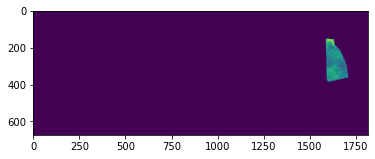

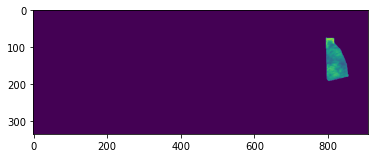

/data4/Ukraine_img/U_band2348/20220329T082601_20220329T083216_T37TDN_cut_reprojection.tif


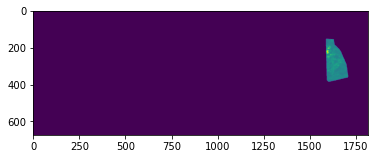

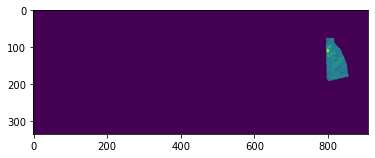

/data4/Ukraine_img/U_band2348/20220622T082609_20220622T082834_T37TDN_cut_reprojection.tif


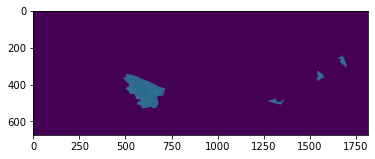

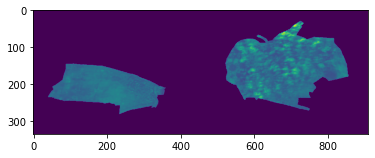

/data4/Ukraine_img/U_band2348/20220227T082911_20220227T083303_T37TCN_cut_reprojection.tif


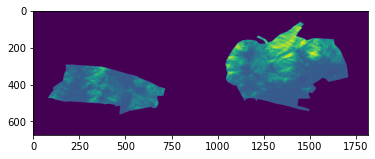

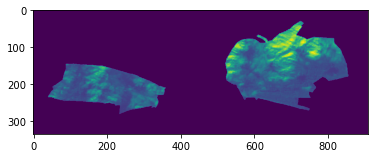

/data4/Ukraine_img/U_band2348/20220314T082719_20220314T083610_T37TDN_cut_reprojection.tif


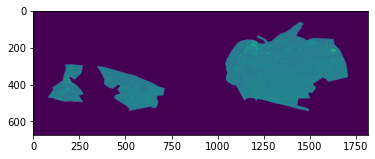

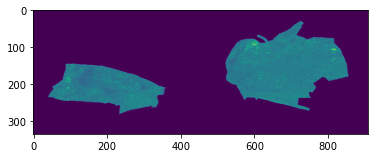

/data4/Ukraine_img/U_band2348/20220503T082559_20220503T083512_T37TCN_cut_reprojection.tif


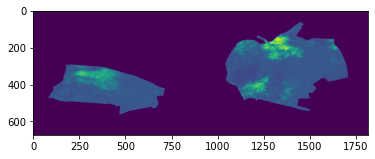

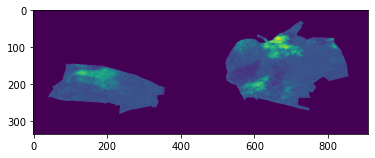

/data4/Ukraine_img/U_band2348/20220627T082621_20220627T083534_T37TDN_cut_reprojection.tif


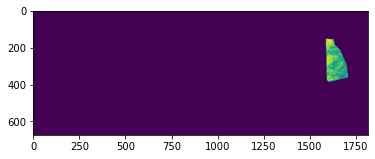

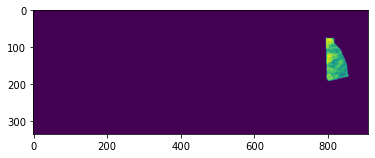

/data4/Ukraine_img/U_band2348/20220309T082801_20220309T083304_T37TCN_cut_reprojection.tif


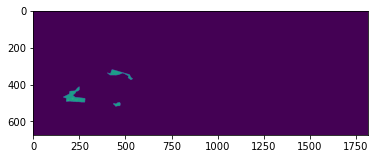

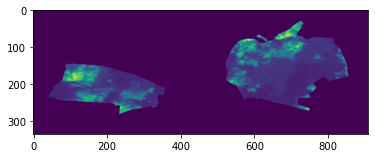

/data4/Ukraine_img/U_band2348/20220222T082839_20220222T082842_T37TDN_cut_reprojection.tif


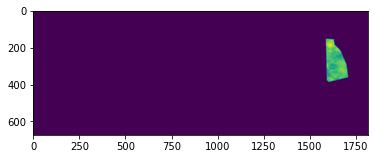

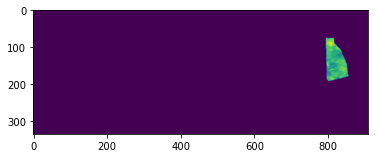

/data4/Ukraine_img/U_band2348/20220408T082601_20220408T083258_T37TDN_cut_reprojection.tif


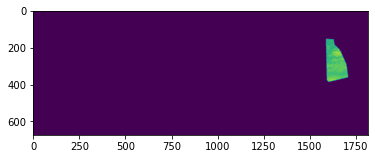

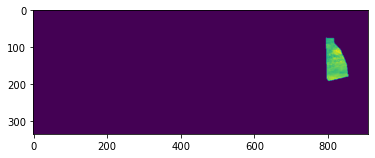

/data4/Ukraine_img/U_band2348/20220622T082609_20220622T082834_T37TCN_cut_reprojection.tif


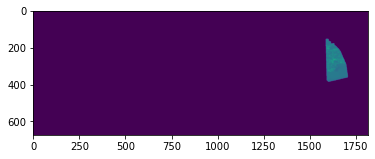

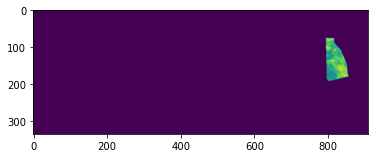

/data4/Ukraine_img/U_band2348/20220314T082719_20220314T083610_T37TCN_cut_reprojection.tif


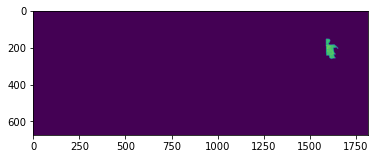

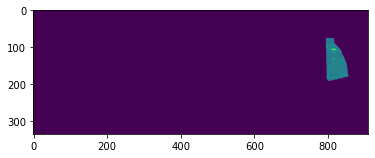

/data4/Ukraine_img/U_band2348/20220523T082559_20220523T082946_T37TCN_cut_reprojection.tif


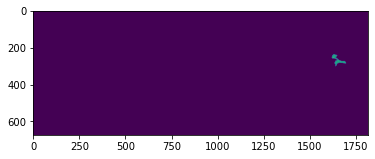

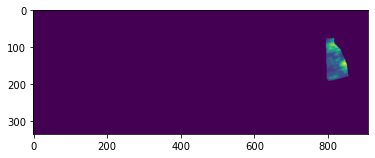

/data4/Ukraine_img/U_band2348/20220428T082611_20220428T083305_T37TDN_cut_reprojection.tif


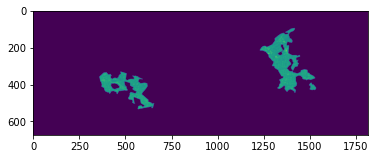

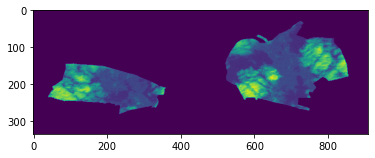

/data4/Ukraine_img/U_band2348/20220607T082611_20220607T083435_T37TCN_cut_reprojection.tif


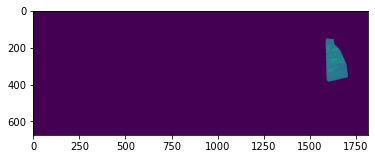

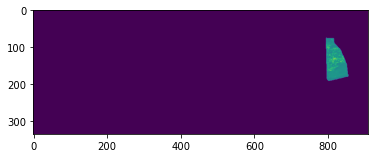

/data4/Ukraine_img/U_band2348/20220403T082559_20220403T083553_T37TDN_cut_reprojection.tif


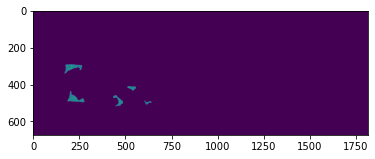

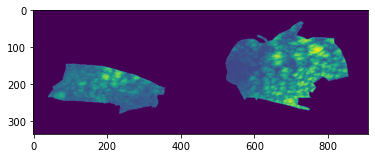

/data4/Ukraine_img/U_band2348/20220612T082609_20220612T082840_T37TCN_cut_reprojection.tif


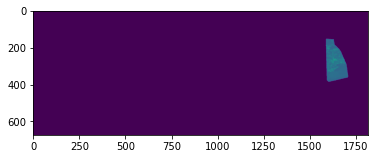

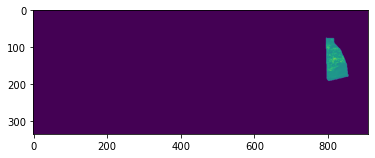

/data4/Ukraine_img/U_band2348/20220523T082559_20220523T082946_T37TDN_cut_reprojection.tif


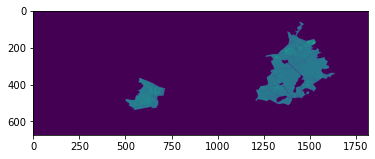

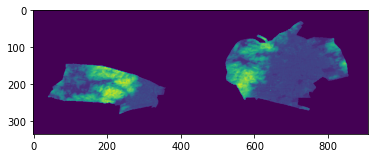

/data4/Ukraine_img/U_band2348/20220329T082601_20220329T083216_T37TCN_cut_reprojection.tif


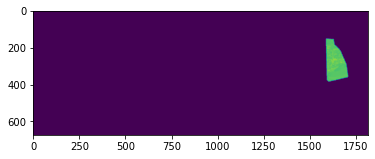

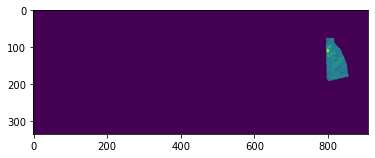

/data4/Ukraine_img/U_band2348/20220617T082611_20220617T083253_T37TCN_cut_reprojection.tif


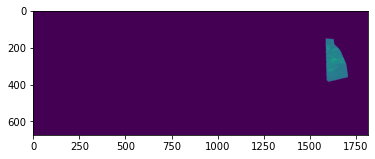

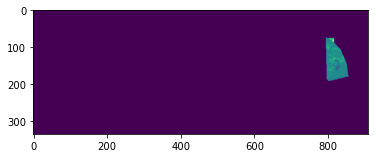

/data4/Ukraine_img/U_band2348/20220627T082621_20220627T083534_T37TCN_cut_reprojection.tif


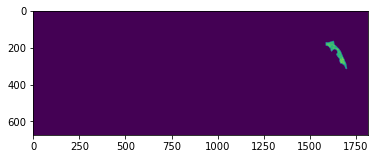

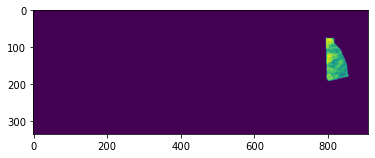

/data4/Ukraine_img/U_band2348/20220508T082611_20220508T083304_T37TCN_cut_reprojection.tif


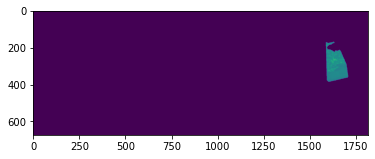

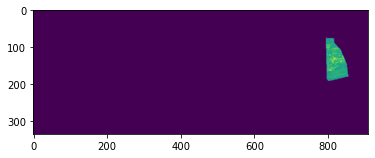

/data4/Ukraine_img/U_band2348/20220222T082839_20220222T082842_T37TCN_cut_reprojection.tif


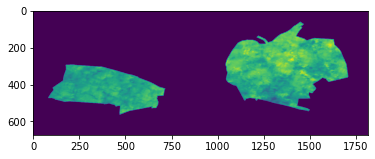

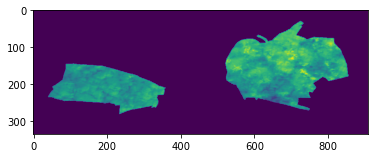

/data4/Ukraine_img/U_band2348/20220428T082611_20220428T083305_T37TCN_cut_reprojection.tif


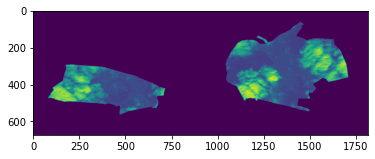

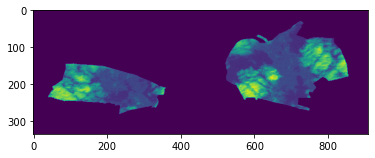

/data4/Ukraine_img/U_band2348/20220324T082609_20220324T083426_T37TCN_cut_reprojection.tif


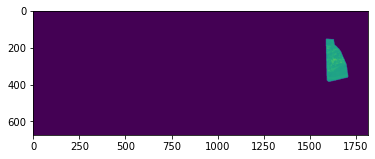

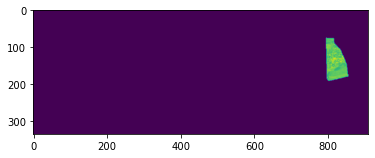

/data4/Ukraine_img/U_band2348/20220602T082559_20220602T082807_T37TCN_cut_reprojection.tif


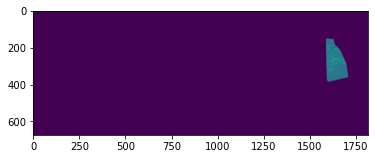

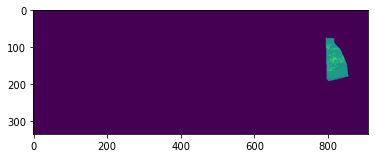

/data4/Ukraine_img/U_band2348/20210910T082601_20210910T083119_T37TCN_cut_reprojection.tif


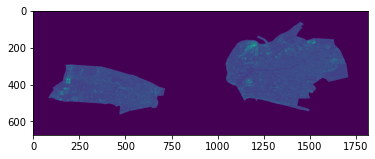

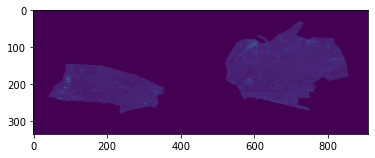

/data4/Ukraine_img/U_band2348/20220528T082611_20220528T083641_T37TDN_cut_reprojection.tif


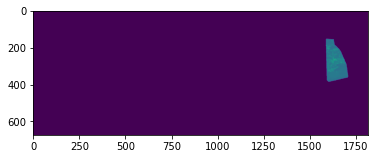

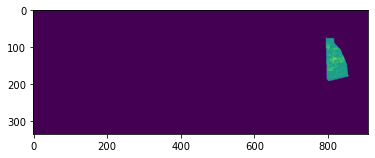

/data4/Ukraine_img/U_band2348/20220319T082651_20220319T083304_T37TDN_cut_reprojection.tif


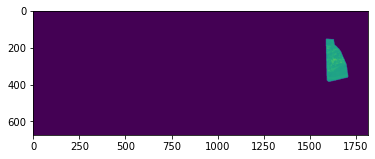

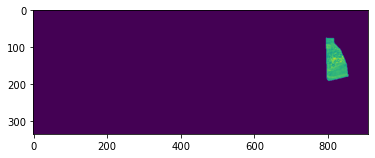

/data4/Ukraine_img/U_band2348/20220612T082609_20220612T082840_T37TDN_cut_reprojection.tif


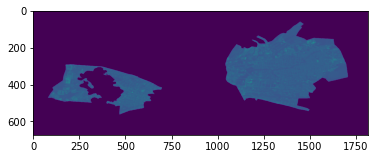

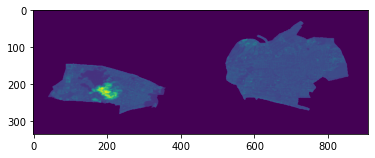

/data4/Ukraine_img/U_band2348/20220513T082559_20220513T082940_T37TCN_cut_reprojection.tif


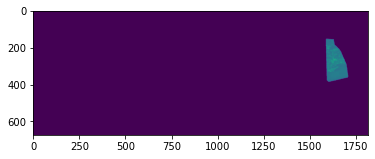

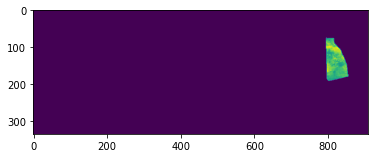

/data4/Ukraine_img/U_band2348/20220513T082559_20220513T082940_T37TDN_cut_reprojection.tif


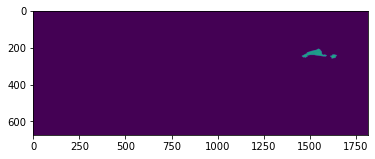

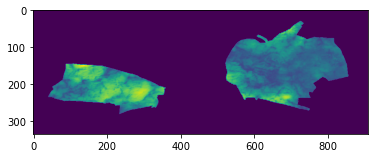

/data4/Ukraine_img/U_band2348/20220319T082651_20220319T083304_T37TCN_cut_reprojection.tif


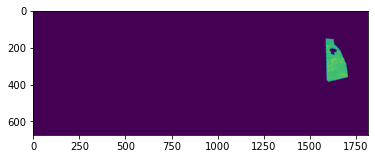

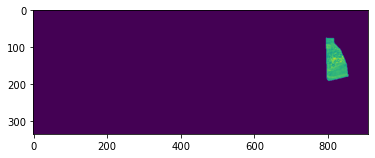

/data4/Ukraine_img/U_band2348/20220602T082559_20220602T082807_T37TDN_cut_reprojection.tif


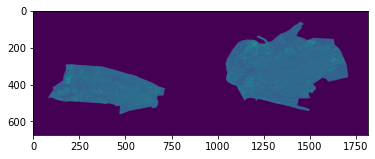

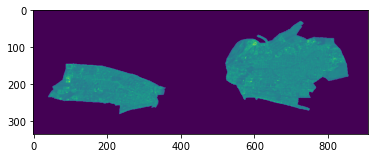

/data4/Ukraine_img/U_band2348/20220508T082611_20220508T083304_T37TDN_cut_reprojection.tif


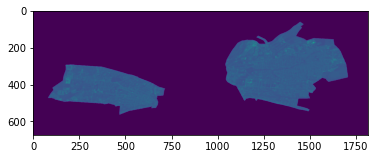

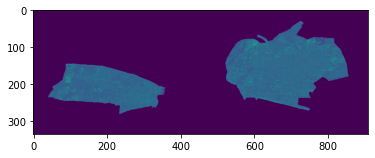

/data4/Ukraine_img/U_band2348/20220418T082611_20220418T083304_T37TCN_cut_reprojection.tif


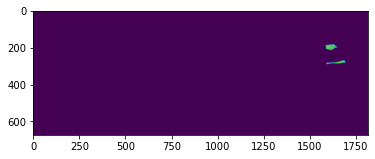

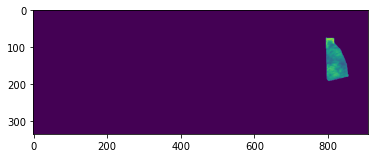

/data4/Ukraine_img/U_band2348/20220528T082611_20220528T083641_T37TCN_cut_reprojection.tif


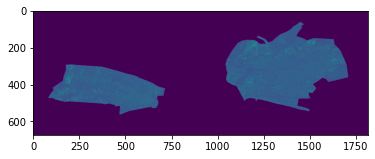

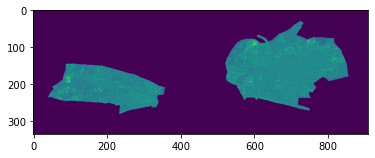

/data4/Ukraine_img/U_band2348/20220617T082611_20220617T083253_T37TDN_cut_reprojection.tif


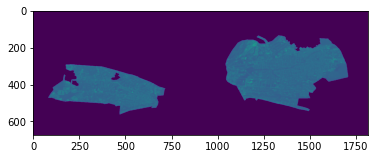

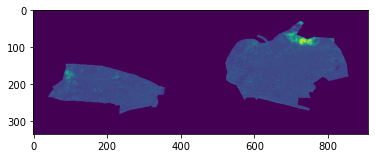

/data4/Ukraine_img/U_band2348/20220607T082611_20220607T083435_T37TDN_cut_reprojection.tif


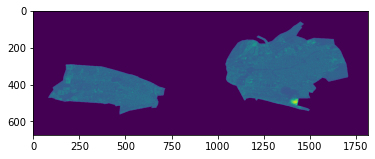

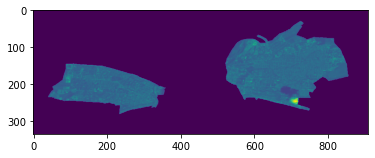

/data4/Ukraine_img/U_band2348/20220309T082801_20220309T083304_T37TDN_cut_reprojection.tif


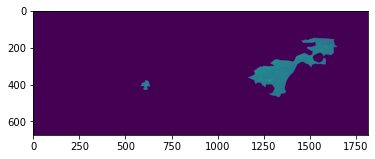

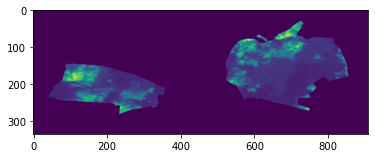

/data4/Ukraine_img/U_band2348/20220403T082559_20220403T083553_T37TCN_cut_reprojection.tif


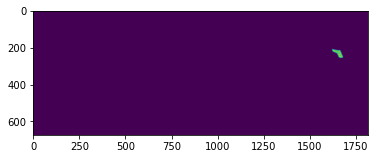

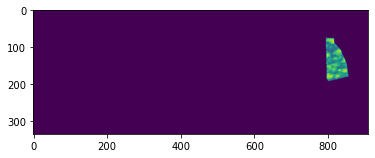

/data4/Ukraine_img/U_band2348/20220324T082609_20220324T083426_T37TDN_cut_reprojection.tif


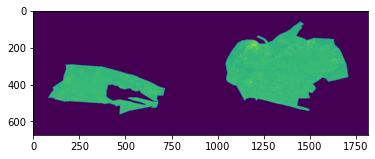

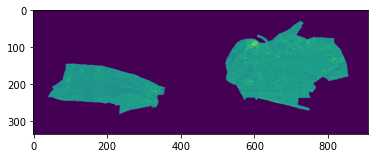

/data4/Ukraine_img/U_band2348/20220503T082559_20220503T083512_T37TDN_cut_reprojection.tif


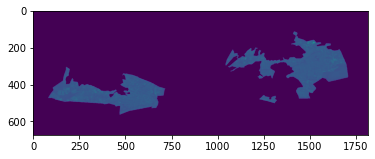

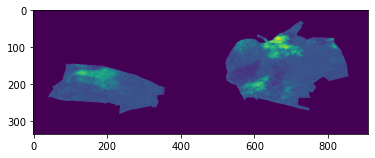

In [6]:
for i in match.keys():
    print(i)
    plt.imshow(read_img(i)['img'][0,:,:])
    plt.show()
    plt.imshow(read_img(match[i])['img'][0,:,:])
    plt.show()

In [369]:
def read_img(path):
    ds=gdal.Open(path)
    trf=ds.GetGeoTransform()
    img=ds.ReadAsArray()
    return {'trf':trf,'img':img}
def get_patch(data,size):
    img=data['img']
    trf=data['trf']
    shape=img.shape
    img=np.pad(img,((0,0),(0,size-shape[1]%size),(0,size-shape[2]%size)),'constant',constant_values=0)
    shape=img.shape
    img=img.reshape([shape[0],int(shape[1]/size),-1,shape[2]])
    shape=img.shape
    img=img.reshape([shape[0],shape[1],shape[2],int(shape[3]/size),-1])
    return {'img':img.transpose((0,1,3,2,4)),'trf':(trf[0]-trf[1]/2,trf[1]*size,trf[2],trf[3]-trf[5]/2,trf[4],trf[5]*size)}

size=6
img_pathes=fs10
# img_pathes=['/data2/Syria_img/Raqqa_enhance-A-B-4_20130213_treated.tif']
print(img_pathes)
for mask_id in [0,1,2,3]:
    mask=area_mask['masks'][mask_id]
    for path in img_pathes:
        # try:    
        
        print(path)
        data=read_img(path)
        for i in range(data['img'].shape[0]):
            data['img'][i,:,:][mask==0]=0
        print(data['img'].shape)
        data2=get_patch(data,size)
        print(data2['img'].shape)
        print(data2['trf'])
        d=data2['img'].astype(np.int16)
        info={'readme':'trf分别为patch左上角坐标(不是左上角像元的中心坐标)和patch的长度','trf':data2['trf'],'shape':[data['img'].shape,d.shape],'img':d}

        np.save(path.replace('.tif',f'_size_{size}.npy'),d)
        print('max:',d.max())
        torch.save(info,path.replace('.tif',f'_size_{size}_area{mask_id+1}_info.pth'))
        del data,data2,d
        gc.collect()
        # except:
        #         print('ERROR',path)

['/data4/Ukraine_img/U_band2348/20220418T082611_20220418T083304_T37TDN_cut_reprojection.tif', '/data4/Ukraine_img/U_band2348/20220329T082601_20220329T083216_T37TDN_cut_reprojection.tif', '/data4/Ukraine_img/U_band2348/20220622T082609_20220622T082834_T37TDN_cut_reprojection.tif', '/data4/Ukraine_img/U_band2348/20220227T082911_20220227T083303_T37TCN_cut_reprojection.tif', '/data4/Ukraine_img/U_band2348/20220314T082719_20220314T083610_T37TDN_cut_reprojection.tif', '/data4/Ukraine_img/U_band2348/20220503T082559_20220503T083512_T37TCN_cut_reprojection.tif', '/data4/Ukraine_img/U_band2348/20220627T082621_20220627T083534_T37TDN_cut_reprojection.tif', '/data4/Ukraine_img/U_band2348/20220309T082801_20220309T083304_T37TCN_cut_reprojection.tif', '/data4/Ukraine_img/U_band2348/20220222T082839_20220222T082842_T37TDN_cut_reprojection.tif', '/data4/Ukraine_img/U_band2348/20220408T082601_20220408T083258_T37TDN_cut_reprojection.tif', '/data4/Ukraine_img/U_band2348/20220622T082609_20220622T082834_T37TCN

In [211]:
size=3
img_pathes=fs20
# img_pathes=['/data2/Syria_img/Raqqa_enhance-A-B-4_20130213_treated.tif']
print(img_pathes)
for mask_id in [4,5,6,7]:
    mask=area_mask['masks'][mask_id]
    for path in img_pathes:
        # try:    

        print(path)
        data=read_img(path)
        for i in range(data['img'].shape[0]):
            data['img'][i,:,:][mask==0]=0
        print(data['img'].shape)
        data2=get_patch(data,size)
        print(data2['img'].shape)
        print(data2['trf'])
        d=data2['img'].astype(np.int16)
        info={'readme':'trf分别为patch左上角坐标(不是左上角像元的中心坐标)和patch的长度','trf':data2['trf'],'shape':[data['img'].shape,d.shape],'img':d}

        np.save(path.replace('.tif',f'_size_{size}.npy'),d)
        print('max:',d.max())
        torch.save(info,path.replace('.tif',f'_size_{size}_area{mask_id-3}_info.pth'))
        del data,data2,d
        gc.collect()

['/data4/Ukraine_img/U_bandother/20220418T082611_20220418T083304_T37TDN_cut_reprojection.tif', '/data4/Ukraine_img/U_bandother/20220329T082601_20220329T083216_T37TDN_cut_reprojection.tif', '/data4/Ukraine_img/U_bandother/20220622T082609_20220622T082834_T37TDN_cut_reprojection.tif', '/data4/Ukraine_img/U_bandother/20210910T082601_20210910T083119_T37TDN_cut_reprojection.tif', '/data4/Ukraine_img/U_bandother/20220227T082911_20220227T083303_T37TCN_cut_reprojection.tif', '/data4/Ukraine_img/U_bandother/20220314T082719_20220314T083610_T37TDN_cut_reprojection.tif', '/data4/Ukraine_img/U_bandother/20220503T082559_20220503T083512_T37TCN_cut_reprojection.tif', '/data4/Ukraine_img/U_bandother/20220627T082621_20220627T083534_T37TDN_cut_reprojection.tif', '/data4/Ukraine_img/U_bandother/20220309T082801_20220309T083304_T37TCN_cut_reprojection.tif', '/data4/Ukraine_img/U_bandother/20220222T082839_20220222T082842_T37TDN_cut_reprojection.tif', '/data4/Ukraine_img/U_bandother/20220408T082601_20220408T08

# 制作patch的label

In [328]:
img_pathes={}
for area in labels_date.keys():
    k={}
    for date_id in labels_date[area].keys():
        date_list=labels_date[area][date_id]
        fl=[]
        for d in date_list:
            fl+=glob(f'/data4/Ukraine_img/U_band2348/{d}*{area}*.pth')
        k[date_id]=fl
    img_pathes[area]=k
img_pathes

{'area1': {'A': ['/data4/Ukraine_img/U_band2348/20210910T082601_20210910T083119_T37TCN_cut_reprojection_size_6_area1_info.pth'],
  'A-B': ['/data4/Ukraine_img/U_band2348/20220222T082839_20220222T082842_T37TDN_cut_reprojection_size_6_area1_info.pth',
   '/data4/Ukraine_img/U_band2348/20220222T082839_20220222T082842_T37TCN_cut_reprojection_size_6_area1_info.pth',
   '/data4/Ukraine_img/U_band2348/20220227T082911_20220227T083303_T37TCN_cut_reprojection_size_6_area1_info.pth',
   '/data4/Ukraine_img/U_band2348/20220309T082801_20220309T083304_T37TCN_cut_reprojection_size_6_area1_info.pth',
   '/data4/Ukraine_img/U_band2348/20220309T082801_20220309T083304_T37TDN_cut_reprojection_size_6_area1_info.pth'],
  'B': ['/data4/Ukraine_img/U_band2348/20220314T082719_20220314T083610_T37TDN_cut_reprojection_size_6_area1_info.pth',
   '/data4/Ukraine_img/U_band2348/20220314T082719_20220314T083610_T37TCN_cut_reprojection_size_6_area1_info.pth'],
  'B-C': ['/data4/Ukraine_img/U_band2348/20220319T082651_20

In [182]:
def get_dam_mask(point,patch_file,weight):
    trf=torch.load(patch_file)['trf']
    shape=torch.load(patch_file)['shape'][1]
    p_coor=[shapely.geometry.mapping(list(point)[i])['coordinates'] for i in range(len(point))]
    mask=np.zeros((shape[1],shape[2]))
    p_x_y=[[int((i[0]-trf[0])/trf[1]),int((i[1]-trf[3])/trf[5])] for i in p_coor]
    for i in p_x_y:
        try:
            mask[i[1],i[0]]+=weight
        except:
            pass
    return mask
def get_mask(points_path,patch_path):
    df=gpd.read_file(points_path)
    print(len(df))
    point_num={}
    point=df[df['DmgCls']=='Destroyed']['geometry']
    point_num['destroyed']=len(point)
    print('destroyed:',len(point))
    mask_destroyed=get_dam_mask(point,patch_path,1)
    point=df[df['DmgCls']=='Severe Damage']['geometry']
    point_num['severe']=len(point)
    print('Severe Damage:',len(point))
    mask_severe=get_dam_mask(point,patch_path,1)
    point=df[df['DmgCls']=='Moderate Damage']['geometry']
    point_num['moderate']=len(point)
    print('Moderate Damage:',len(point))
    mask_moderate=get_dam_mask(point,patch_path,1)

    mask=mask_destroyed*6+mask_severe*3+mask_moderate
    date=df['SensDt'][0]
    print(f'{n}  {date}得分',dict(Counter(list(mask.flatten()))))
    mask_type=np.zeros(mask.shape)
    mask_type[mask>0]=1
    mask_type[mask>=6]=2
    print(f'{date}损毁类型',Counter(list(mask_type.flatten())))
    all_mask=[mask_destroyed,mask_severe,mask_moderate,mask,mask_type]
    info='5层分别为完全 严重 中等 以及损毁得分和类型\n得分:完全算6分 严重算3分 中等算1分 其他0分\n类型0:得分0 类型1:得分1-5 类型2:得分大于6'
    result={'info':info,'point_num':point_num,'mask':all_mask}
    return result

In [284]:
points_list=['/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_B_2022-03-14.shp','/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C-Area1_2022-05-12.shp',
'/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C-Area2_2022-05-08.shp','/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C-Area1-4_2022-05-07.shp']
for point_path in points_list:
    patch_path='/data4/Ukraine_img/U_band2348/20210910T082601_20210910T083119_T37TCN_cut_reprojection_size_6_info.pth'
    result=get_mask(point_path,patch_path)
    torch.save(result,point_path.replace('.shp','_size_6_dammask.pth.tar'))
    print('__________________________SAVE SUCCESS__________________________')

for point_path in points_list:
    patch_path='/data4/Ukraine_img/U_bandother/20210910T082601_20210910T083119_T37TCN_cut_reprojection_size_3_info.pth'
    result=get_mask(point_path,patch_path)
    torch.save(result,point_path.replace('.shp','_size_3_dammask.pth.tar'))
    print('__________________________SAVE SUCCESS__________________________')


750
destroyed: 61
Severe Damage: 300
Moderate Damage: 311
Hama  2022-03-14得分 {0.0: 33844, 3.0: 173, 6.0: 52, 1.0: 204, 4.0: 19, 9.0: 14, 7.0: 8, 2.0: 16, 8.0: 2, 15.0: 4, 11.0: 1, 18.0: 2, 20.0: 1, 14.0: 2, 5.0: 5, 10.0: 2, 12.0: 3}
2022-03-14损毁类型 Counter({0.0: 33844, 1.0: 417, 2.0: 91})
__________________________SAVE SUCCESS__________________________
2919
destroyed: 168
Severe Damage: 930
Moderate Damage: 1697
Hama  2022-05-12得分 {0.0: 33068, 3.0: 166, 1.0: 551, 5.0: 52, 4.0: 80, 2.0: 120, 6.0: 61, 10.0: 27, 15.0: 11, 7.0: 41, 25.0: 2, 8.0: 19, 11.0: 17, 9.0: 32, 12.0: 19, 13.0: 15, 22.0: 4, 27.0: 1, 24.0: 4, 18.0: 6, 16.0: 7, 23.0: 4, 20.0: 5, 21.0: 5, 19.0: 11, 14.0: 12, 17.0: 3, 26.0: 2, 45.0: 1, 30.0: 2, 32.0: 2, 33.0: 1, 28.0: 1}
2022-05-12损毁类型 Counter({0.0: 33068, 1.0: 969, 2.0: 315})
__________________________SAVE SUCCESS__________________________
1826
destroyed: 87
Severe Damage: 789
Moderate Damage: 909
Hama  2022-05-08得分 {0.0: 33447, 3.0: 192, 1.0: 319, 6.0: 73, 2.0: 72, 4.0:

In [50]:
dammasks_path={}
for i in points_path.keys():
    k={}
    k['A']=None
    for j in points_path[i].keys():
        if points_path[i][j] is not None:
            k[j]=points_path[i][j].replace('.shp','_size_3_dammask.pth.tar')
    k['Z']=None
    dammasks_path[i]=k
dammasks_path

{'area1': {'A': None,
  'B': '/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_B_2022-03-14_size_3_dammask.pth.tar',
  'C': '/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C-Area1_2022-05-12_size_3_dammask.pth.tar',
  'Z': None},
 'area2': {'A': None,
  'B': '/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_B_2022-03-14_size_3_dammask.pth.tar',
  'C': '/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C-Area2_2022-05-08_size_3_dammask.pth.tar',
  'Z': None},
 'area3': {'A': None,
  'B': '/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_B_2022-03-14_size_3_dammask.pth.tar',
  'Z': None},
 'area4': {'A': None,
  'B': '/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_B_2022-03-14_size_3_dammask.pth.tar',
  'C': '/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C-Area1-4_2022-05-07_size_3_dammask.pth.tar',
  'Z': None}}

# 制作样本

In [51]:
# masks={
#     'A':None,
#     'B':glob(f'/data2/Syria_img/{city}_B_*_treated_size_120_dammask.pth.tar')[0],
#     'C':glob(f'/data2/Syria_img/{city}_C_*_treated_size_120_dammask.pth.tar')[0],
#     'D':glob(f'/data2/Syria_img/{city}_D_*_treated_size_120_dammask.pth.tar')[0],
#     'Z':None
# }


def get_samples(pre_patch,post_patch,dammask_after,dammask_now,dammask_before):
        # if pre_patch[0].shape!=post_patch[0].shape:
        #         raise('SHAPE ERROR')
        if pre_patch[0].shape[0]!=4 or post_patch[0].shape[0]!=4:
                raise
        if pre_patch[1].shape[0]!=6 or post_patch[1].shape[0]!=6:
                raise
                               
        shape=pre_patch[0].shape
        print(shape)
        zz=np.zeros((shape[1],shape[2]))
        samples=[]
        if dammask_now is not None:
                for x in range(shape[1]):
                        for y in range(shape[2]):
                                
                                if (pre_patch[0][:,x,y]==0).any() or (post_patch[0][:,x,y]==0).any() or (pre_patch[1][:,x,y]==0).any() or (post_patch[1][:,x,y]==0).any():
                                        continue
                                else:
                                        samples.append([[x,y],[None,[int(i[x,y]) for i in dammask_now['mask']]],np.concatenate([pre_patch[0][:,x,y],post_patch[0][:,x,y]],axis=0),np.concatenate([pre_patch[1][:,x,y],post_patch[1][:,x,y]],axis=0)])
                                        zz[x,y]=1
        else:
                if dammask_before is None:
                        for x in range(shape[1]):
                                for y in range(shape[2]):
                                        
                                        if (pre_patch[0][:,x,y]==0).any() or (post_patch[0][:,x,y]==0).any() or (pre_patch[1][:,x,y]==0).any() or (post_patch[1][:,x,y]==0).any():
                                                continue
                                        else:
                                                if dammask_after['mask'][0][x,y]==0:
                                                        samples.append([[x,y],[None,[int(i[x,y]) for i in dammask_after['mask']]],np.concatenate([pre_patch[0][:,x,y],post_patch[0][:,x,y]],axis=0),np.concatenate([pre_patch[1][:,x,y],post_patch[1][:,x,y]],axis=0)])
                                                        zz[x,y]=1
                if dammask_after is None:
                        for x in range(shape[1]):
                                for y in range(shape[2]):
                                        
                                        if (pre_patch[0][:,x,y]==0).any() or (post_patch[0][:,x,y]==0).any() or (pre_patch[1][:,x,y]==0).any() or (post_patch[1][:,x,y]==0).any():
                                                continue
                                        else:
                                                if dammask_before['mask'][0][x,y]>0:
                                                        samples.append([[x,y],[[int(i[x,y]) for i in dammask_before['mask']],None],np.concatenate([pre_patch[0][:,x,y],post_patch[0][:,x,y]],axis=0),np.concatenate([pre_patch[1][:,x,y],post_patch[1][:,x,y]],axis=0)])
                                                        zz[x,y]=1
                if dammask_before is not None and dammask_after is not None:
                        for x in range(shape[1]):
                                for y in range(shape[2]):
                                        
                                        if (pre_patch[0][:,x,y]==0).any() or (post_patch[0][:,x,y]==0).any() or (pre_patch[1][:,x,y]==0).any() or (post_patch[1][:,x,y]==0).any():
                                                continue
                                        else:
                                                if (dammask_after['mask'][0][x,y]>0 and dammask_before['mask'][0][x,y]>0) or (dammask_after['mask'][0][x,y]==0 and dammask_before['mask'][0][x,y]==0):
                                                        samples.append([[x,y],[[int(i[x,y]) for i in dammask_before['mask']],[int(i[x,y]) for i in dammask_after['mask']]],np.concatenate([pre_patch[0][:,x,y],post_patch[0][:,x,y]],axis=0),np.concatenate([pre_patch[1][:,x,y],post_patch[1][:,x,y]],axis=0)])
                                                        zz[x,y]=1
                                        
        return samples,zz

In [52]:
img_pathes={}
for area in labels_date.keys():
    k={}
    for date_id in labels_date[area].keys():
        date_list=labels_date[area][date_id]
        fl=[]
        for d in date_list:
            fl+=glob(f'/data4/Ukraine_img/U_band2348/{d}*{area}*.pth')
        k[date_id]=fl
    img_pathes[area]=k
img_pathes

{'area1': {'A': ['/data4/Ukraine_img/U_band2348/20210910T082601_20210910T083119_T37TCN_cut_reprojection_size_6_area1_info.pth'],
  'A-B': ['/data4/Ukraine_img/U_band2348/20220222T082839_20220222T082842_T37TDN_cut_reprojection_size_6_area1_info.pth',
   '/data4/Ukraine_img/U_band2348/20220222T082839_20220222T082842_T37TCN_cut_reprojection_size_6_area1_info.pth',
   '/data4/Ukraine_img/U_band2348/20220227T082911_20220227T083303_T37TCN_cut_reprojection_size_6_area1_info.pth',
   '/data4/Ukraine_img/U_band2348/20220309T082801_20220309T083304_T37TCN_cut_reprojection_size_6_area1_info.pth',
   '/data4/Ukraine_img/U_band2348/20220309T082801_20220309T083304_T37TDN_cut_reprojection_size_6_area1_info.pth'],
  'B': ['/data4/Ukraine_img/U_band2348/20220314T082719_20220314T083610_T37TDN_cut_reprojection_size_6_area1_info.pth',
   '/data4/Ukraine_img/U_band2348/20220314T082719_20220314T083610_T37TCN_cut_reprojection_size_6_area1_info.pth'],
  'B-C': ['/data4/Ukraine_img/U_band2348/20220319T082651_20

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-------------------------------------
['A', 'A-B', 'B', 'B-C', 'C', 'C-Z']


A-B
loading mask: B
/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_B_2022-03-14_size_3_dammask.pth.tar
load img: A-B
['/data4/Ukraine_img/U_band2348/20220222T082839_20220222T082842_T37TCN_cut_reprojection_size_6_area1_info.pth', '/data4/Ukraine_img/U_band2348/20220222T082839_20220222T082842_T37TDN_cut_reprojection_size_6_area1_info.pth', '/data4/Ukraine_img/U_band2348/20220227T082911_20220227T083303_T37TCN_cut_reprojection_size_6_area1_info.pth', '/data4/Ukraine_img/U_band2348/20220309T082801_20220309T083304_T37TCN_cut_reprojection_size_6_area1_info.pth', '/data4/Ukraine_img/U_band2348/20220309T082801_20220309T083304_T37TDN_cut_reprojection_size_6_area1_info.pth']
/data4/Ukraine_img/U_band2348/20220222T082839_20220222T082842_T37TCN_cut_reprojection_size_6_area1_info.pth


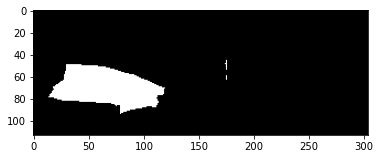

(4, 113, 304, 6, 6)
writing samples 2684


100%|██████████| 2684/2684 [00:00<00:00, 11404.97it/s]


/data4/Ukraine_img/U_band2348/20220222T082839_20220222T082842_T37TDN_cut_reprojection_size_6_area1_info.pth


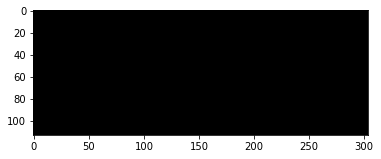

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220227T082911_20220227T083303_T37TCN_cut_reprojection_size_6_area1_info.pth


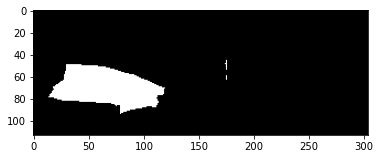

(4, 113, 304, 6, 6)
writing samples 2684


100%|██████████| 2684/2684 [00:00<00:00, 10819.60it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220309T082801_20220309T083304_T37TCN_cut_reprojection_size_6_area1_info.pth


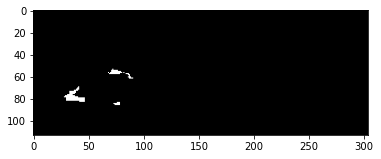

(4, 113, 304, 6, 6)
writing samples 117


100%|██████████| 117/117 [00:00<00:00, 5143.85it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220309T082801_20220309T083304_T37TDN_cut_reprojection_size_6_area1_info.pth


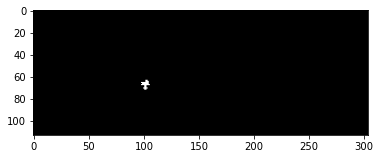

(4, 113, 304, 6, 6)
writing samples 22


100%|██████████| 22/22 [00:00<00:00, 3464.54it/s]



B
loading mask: B
/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_B_2022-03-14_size_3_dammask.pth.tar
load img: B
['/data4/Ukraine_img/U_band2348/20220314T082719_20220314T083610_T37TCN_cut_reprojection_size_6_area1_info.pth', '/data4/Ukraine_img/U_band2348/20220314T082719_20220314T083610_T37TDN_cut_reprojection_size_6_area1_info.pth']
/data4/Ukraine_img/U_band2348/20220314T082719_20220314T083610_T37TCN_cut_reprojection_size_6_area1_info.pth


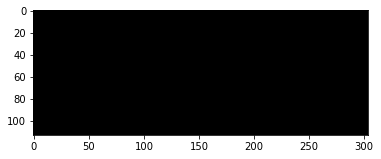

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220314T082719_20220314T083610_T37TDN_cut_reprojection_size_6_area1_info.pth


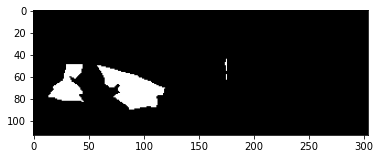

(4, 113, 304, 6, 6)
writing samples 1679


100%|██████████| 1679/1679 [00:00<00:00, 10841.65it/s]




B-C
loading mask: B and C
/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_B_2022-03-14_size_3_dammask.pth.tar
/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C-Area1_2022-05-12_size_3_dammask.pth.tar
load img: B-C
['/data4/Ukraine_img/U_band2348/20220319T082651_20220319T083304_T37TCN_cut_reprojection_size_6_area1_info.pth', '/data4/Ukraine_img/U_band2348/20220319T082651_20220319T083304_T37TDN_cut_reprojection_size_6_area1_info.pth', '/data4/Ukraine_img/U_band2348/20220324T082609_20220324T083426_T37TCN_cut_reprojection_size_6_area1_info.pth', '/data4/Ukraine_img/U_band2348/20220324T082609_20220324T083426_T37TDN_cut_reprojection_size_6_area1_info.pth', '/data4/Ukraine_img/U_band2348/20220329T082601_20220329T083216_T37TCN_cut_reprojection_size_6_area1_info.pth', '/data4/Ukraine_img/U_band2348/20220329T082601_20220329T083216_T37TDN_cut_reprojection_size_6_area1_info.pth', '/data4/Ukraine_img/U_band2348/20220403T082559_20220403T083553_T37TCN_cut_reprojection_size_6_a

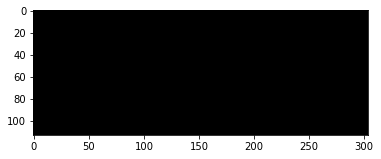

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]

/data4/Ukraine_img/U_band2348/20220319T082651_20220319T083304_T37TDN_cut_reprojection_size_6_area1_info.pth


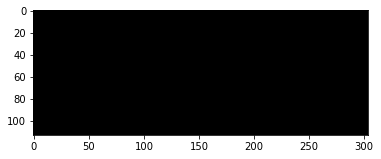

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]

/data4/Ukraine_img/U_band2348/20220324T082609_20220324T083426_T37TCN_cut_reprojection_size_6_area1_info.pth


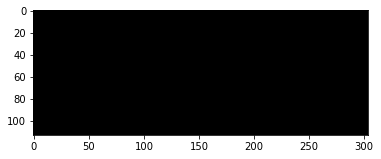

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220324T082609_20220324T083426_T37TDN_cut_reprojection_size_6_area1_info.pth


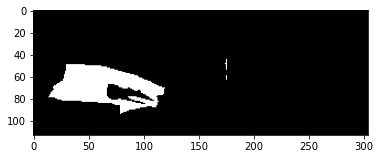

(4, 113, 304, 6, 6)
writing samples 2179


100%|██████████| 2179/2179 [00:00<00:00, 11380.61it/s]


/data4/Ukraine_img/U_band2348/20220329T082601_20220329T083216_T37TCN_cut_reprojection_size_6_area1_info.pth


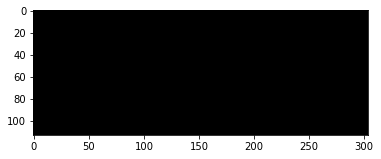

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]

/data4/Ukraine_img/U_band2348/20220329T082601_20220329T083216_T37TDN_cut_reprojection_size_6_area1_info.pth


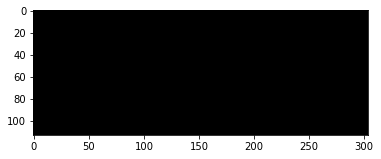

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]

/data4/Ukraine_img/U_band2348/20220403T082559_20220403T083553_T37TCN_cut_reprojection_size_6_area1_info.pth


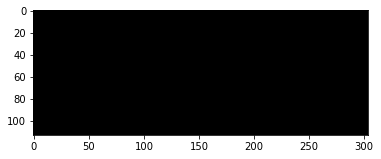

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220403T082559_20220403T083553_T37TDN_cut_reprojection_size_6_area1_info.pth


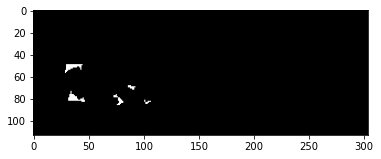

(4, 113, 304, 6, 6)
writing samples 95


100%|██████████| 95/95 [00:00<00:00, 4457.58it/s]

/data4/Ukraine_img/U_band2348/20220408T082601_20220408T083258_T37TDN_cut_reprojection_size_6_area1_info.pth


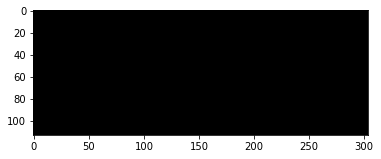

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]

/data4/Ukraine_img/U_band2348/20220418T082611_20220418T083304_T37TCN_cut_reprojection_size_6_area1_info.pth


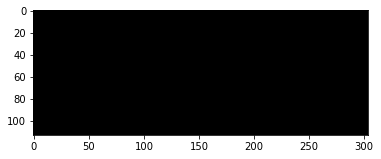

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]

/data4/Ukraine_img/U_band2348/20220418T082611_20220418T083304_T37TDN_cut_reprojection_size_6_area1_info.pth


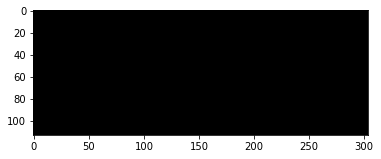

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220428T082611_20220428T083305_T37TCN_cut_reprojection_size_6_area1_info.pth


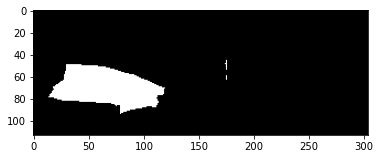

(4, 113, 304, 6, 6)
writing samples 2621


100%|██████████| 2621/2621 [00:00<00:00, 11698.24it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220428T082611_20220428T083305_T37TDN_cut_reprojection_size_6_area1_info.pth


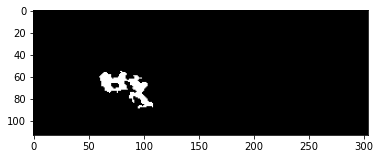

(4, 113, 304, 6, 6)
writing samples 436


100%|██████████| 436/436 [00:00<00:00, 8049.35it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220503T082559_20220503T083512_T37TCN_cut_reprojection_size_6_area1_info.pth


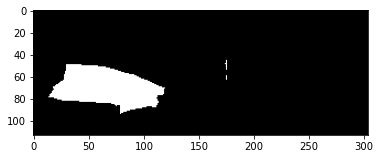

(4, 113, 304, 6, 6)
writing samples 2621


100%|██████████| 2621/2621 [00:00<00:00, 11254.82it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220503T082559_20220503T083512_T37TDN_cut_reprojection_size_6_area1_info.pth


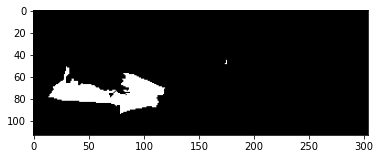

(4, 113, 304, 6, 6)
writing samples 1617


100%|██████████| 1617/1617 [00:00<00:00, 10878.53it/s]


/data4/Ukraine_img/U_band2348/20220508T082611_20220508T083304_T37TCN_cut_reprojection_size_6_area1_info.pth


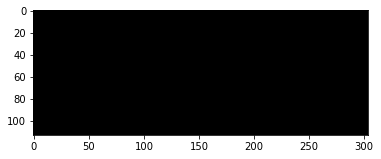

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220508T082611_20220508T083304_T37TDN_cut_reprojection_size_6_area1_info.pth


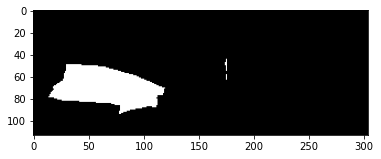

(4, 113, 304, 6, 6)
writing samples 2619


100%|██████████| 2619/2619 [00:00<00:00, 10182.59it/s]




C
loading mask: C
/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C-Area1_2022-05-12_size_3_dammask.pth.tar


C-Z
loading mask: C
/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C-Area1_2022-05-12_size_3_dammask.pth.tar
load img: C-Z
['/data4/Ukraine_img/U_band2348/20220513T082559_20220513T082940_T37TCN_cut_reprojection_size_6_area1_info.pth', '/data4/Ukraine_img/U_band2348/20220513T082559_20220513T082940_T37TDN_cut_reprojection_size_6_area1_info.pth', '/data4/Ukraine_img/U_band2348/20220523T082559_20220523T082946_T37TCN_cut_reprojection_size_6_area1_info.pth', '/data4/Ukraine_img/U_band2348/20220523T082559_20220523T082946_T37TDN_cut_reprojection_size_6_area1_info.pth', '/data4/Ukraine_img/U_band2348/20220528T082611_20220528T083641_T37TCN_cut_reprojection_size_6_area1_info.pth', '/data4/Ukraine_img/U_band2348/20220528T082611_20220528T083641_T37TDN_cut_reprojection_size_6_area1_info.pth', '/data4/Ukraine_img/U_band2348/20220602T082559_20220602T082807_T37TCN_cut_r

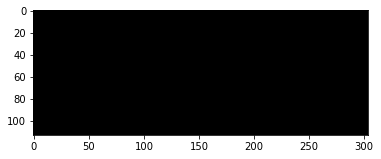

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]

/data4/Ukraine_img/U_band2348/20220513T082559_20220513T082940_T37TDN_cut_reprojection_size_6_area1_info.pth


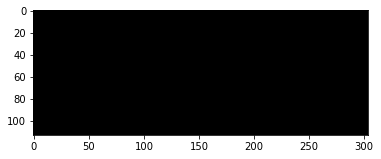

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]

/data4/Ukraine_img/U_band2348/20220523T082559_20220523T082946_T37TCN_cut_reprojection_size_6_area1_info.pth


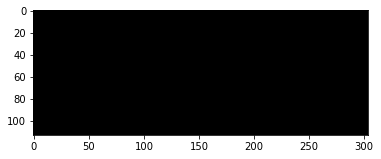

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220523T082559_20220523T082946_T37TDN_cut_reprojection_size_6_area1_info.pth


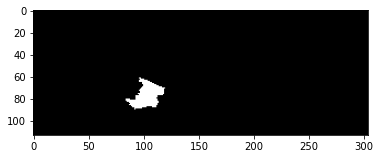

(4, 113, 304, 6, 6)
writing samples 46


100%|██████████| 46/46 [00:00<00:00, 3730.14it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220528T082611_20220528T083641_T37TCN_cut_reprojection_size_6_area1_info.pth


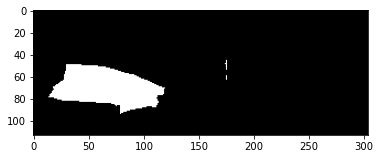

(4, 113, 304, 6, 6)
writing samples 115


100%|██████████| 115/115 [00:00<00:00, 6904.25it/s]

/data4/Ukraine_img/U_band2348/20220528T082611_20220528T083641_T37TDN_cut_reprojection_size_6_area1_info.pth


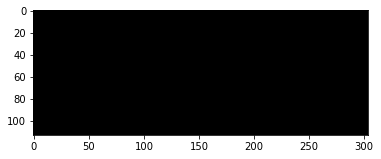

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]

/data4/Ukraine_img/U_band2348/20220602T082559_20220602T082807_T37TCN_cut_reprojection_size_6_area1_info.pth


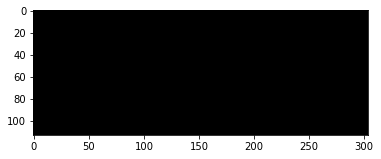

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220602T082559_20220602T082807_T37TDN_cut_reprojection_size_6_area1_info.pth


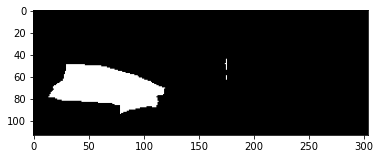

(4, 113, 304, 6, 6)
writing samples 115


100%|██████████| 115/115 [00:00<00:00, 7492.62it/s]

/data4/Ukraine_img/U_band2348/20220607T082611_20220607T083435_T37TCN_cut_reprojection_size_6_area1_info.pth


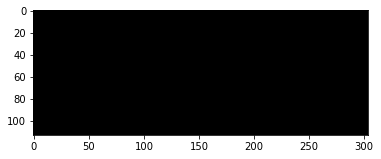

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220607T082611_20220607T083435_T37TDN_cut_reprojection_size_6_area1_info.pth


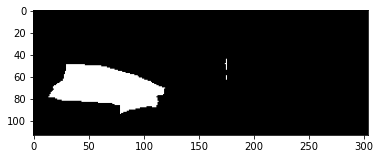

(4, 113, 304, 6, 6)
writing samples 115


100%|██████████| 115/115 [00:00<00:00, 6158.56it/s]

/data4/Ukraine_img/U_band2348/20220612T082609_20220612T082840_T37TCN_cut_reprojection_size_6_area1_info.pth


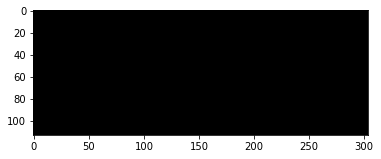

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220612T082609_20220612T082840_T37TDN_cut_reprojection_size_6_area1_info.pth


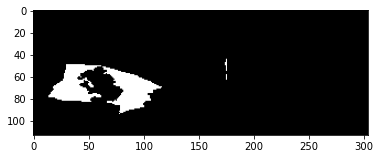

(4, 113, 304, 6, 6)
writing samples 62


100%|██████████| 62/62 [00:00<00:00, 4321.01it/s]

/data4/Ukraine_img/U_band2348/20220617T082611_20220617T083253_T37TCN_cut_reprojection_size_6_area1_info.pth


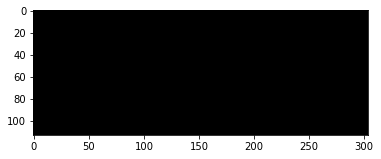

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220617T082611_20220617T083253_T37TDN_cut_reprojection_size_6_area1_info.pth


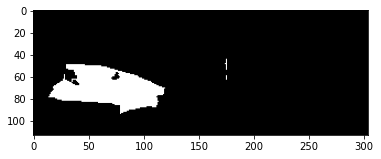

(4, 113, 304, 6, 6)
writing samples 114


100%|██████████| 114/114 [00:00<00:00, 5448.33it/s]

/data4/Ukraine_img/U_band2348/20220622T082609_20220622T082834_T37TCN_cut_reprojection_size_6_area1_info.pth


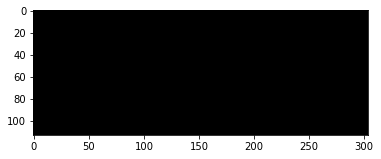

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220622T082609_20220622T082834_T37TDN_cut_reprojection_size_6_area1_info.pth


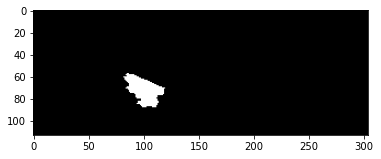

(4, 113, 304, 6, 6)
writing samples 45


100%|██████████| 45/45 [00:00<00:00, 3904.02it/s]

/data4/Ukraine_img/U_band2348/20220627T082621_20220627T083534_T37TCN_cut_reprojection_size_6_area1_info.pth


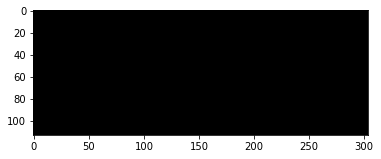

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]

/data4/Ukraine_img/U_band2348/20220627T082621_20220627T083534_T37TDN_cut_reprojection_size_6_area1_info.pth


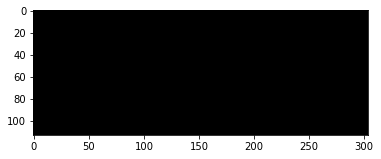

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-------------------------------------
['A', 'A-B', 'B', 'B-C', 'C', 'C-Z']


A-B
loading mask: B
/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_B_2022-03-14_size_3_dammask.pth.tar
load img: A-B
['/data4/Ukraine_img/U_band2348/20220222T082839_20220222T082842_T37TCN_cut_reprojection_size_6_area2_info.pth', '/data4/Ukraine_img/U_band2348/20220222T082839_20220222T082842_T37TDN_cut_reprojection_size_6_area2_info.pth', '/data4/Ukraine_img/U_band2348/20220227T082911_20220227T083303_T37TCN_cut_reprojection_size_6_area2_info.pth', '/data4/Ukraine_img/U_band2348/20220309T082801_20220309T083304_T37TCN_cut_reprojection_size_6_area2_info.pth', '/data4/Ukraine_img/U_band2348/20220309T082801_20220309T083304_T37TDN_cut_reprojection_size_6_area2_info.pth']
/data4/Ukraine_img/U_band2348/20220222T082839_20220222T082842_T37TCN_cut_reprojection_size_6_area2_info.pth


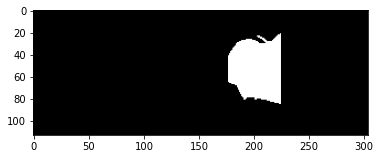

(4, 113, 304, 6, 6)
writing samples 2264


100%|██████████| 2264/2264 [00:00<00:00, 11550.94it/s]


/data4/Ukraine_img/U_band2348/20220222T082839_20220222T082842_T37TDN_cut_reprojection_size_6_area2_info.pth


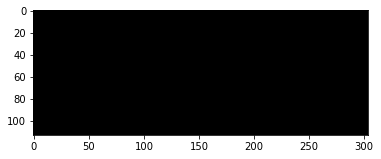

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220227T082911_20220227T083303_T37TCN_cut_reprojection_size_6_area2_info.pth


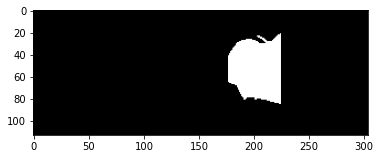

(4, 113, 304, 6, 6)
writing samples 2264


100%|██████████| 2264/2264 [00:00<00:00, 11439.84it/s]


/data4/Ukraine_img/U_band2348/20220309T082801_20220309T083304_T37TCN_cut_reprojection_size_6_area2_info.pth


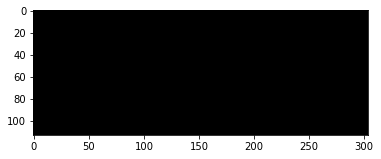

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220309T082801_20220309T083304_T37TDN_cut_reprojection_size_6_area2_info.pth


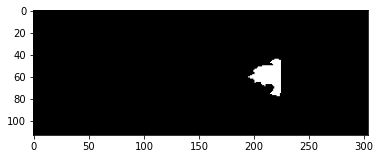

(4, 113, 304, 6, 6)
writing samples 451


100%|██████████| 451/451 [00:00<00:00, 8741.61it/s]



B
loading mask: B
/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_B_2022-03-14_size_3_dammask.pth.tar
load img: B
['/data4/Ukraine_img/U_band2348/20220314T082719_20220314T083610_T37TCN_cut_reprojection_size_6_area2_info.pth', '/data4/Ukraine_img/U_band2348/20220314T082719_20220314T083610_T37TDN_cut_reprojection_size_6_area2_info.pth']
/data4/Ukraine_img/U_band2348/20220314T082719_20220314T083610_T37TCN_cut_reprojection_size_6_area2_info.pth


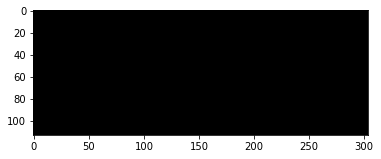

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220314T082719_20220314T083610_T37TDN_cut_reprojection_size_6_area2_info.pth


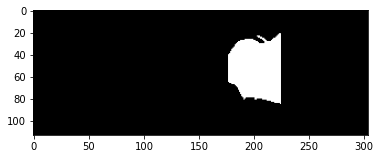

(4, 113, 304, 6, 6)
writing samples 2265


100%|██████████| 2265/2265 [00:00<00:00, 11307.00it/s]




B-C
loading mask: B and C
/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_B_2022-03-14_size_3_dammask.pth.tar
/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C-Area2_2022-05-08_size_3_dammask.pth.tar
load img: B-C
['/data4/Ukraine_img/U_band2348/20220319T082651_20220319T083304_T37TCN_cut_reprojection_size_6_area2_info.pth', '/data4/Ukraine_img/U_band2348/20220319T082651_20220319T083304_T37TDN_cut_reprojection_size_6_area2_info.pth', '/data4/Ukraine_img/U_band2348/20220324T082609_20220324T083426_T37TCN_cut_reprojection_size_6_area2_info.pth', '/data4/Ukraine_img/U_band2348/20220324T082609_20220324T083426_T37TDN_cut_reprojection_size_6_area2_info.pth', '/data4/Ukraine_img/U_band2348/20220329T082601_20220329T083216_T37TCN_cut_reprojection_size_6_area2_info.pth', '/data4/Ukraine_img/U_band2348/20220329T082601_20220329T083216_T37TDN_cut_reprojection_size_6_area2_info.pth', '/data4/Ukraine_img/U_band2348/20220403T082559_20220403T083553_T37TCN_cut_reprojection_size_6_a

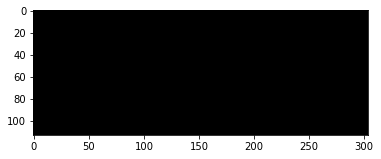

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]

/data4/Ukraine_img/U_band2348/20220319T082651_20220319T083304_T37TDN_cut_reprojection_size_6_area2_info.pth


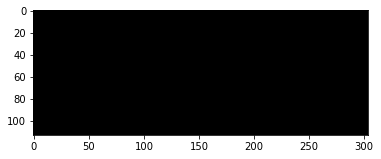

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]

/data4/Ukraine_img/U_band2348/20220324T082609_20220324T083426_T37TCN_cut_reprojection_size_6_area2_info.pth


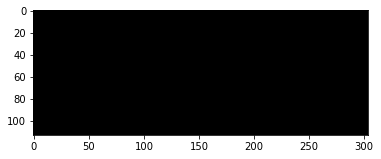

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220324T082609_20220324T083426_T37TDN_cut_reprojection_size_6_area2_info.pth


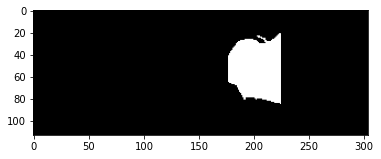

(4, 113, 304, 6, 6)
writing samples 2191


100%|██████████| 2191/2191 [00:00<00:00, 11599.99it/s]


/data4/Ukraine_img/U_band2348/20220329T082601_20220329T083216_T37TCN_cut_reprojection_size_6_area2_info.pth


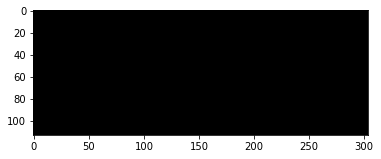

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220329T082601_20220329T083216_T37TDN_cut_reprojection_size_6_area2_info.pth


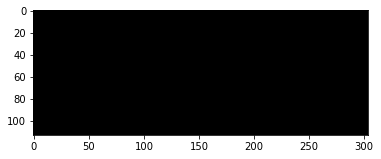

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220403T082559_20220403T083553_T37TCN_cut_reprojection_size_6_area2_info.pth


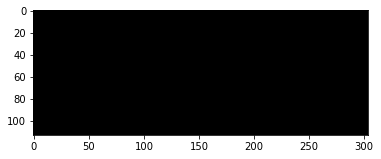

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220403T082559_20220403T083553_T37TDN_cut_reprojection_size_6_area2_info.pth


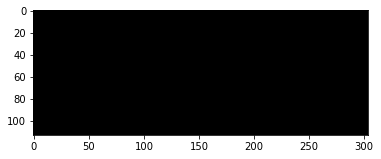

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220408T082601_20220408T083258_T37TDN_cut_reprojection_size_6_area2_info.pth


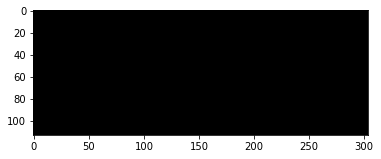

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220418T082611_20220418T083304_T37TCN_cut_reprojection_size_6_area2_info.pth


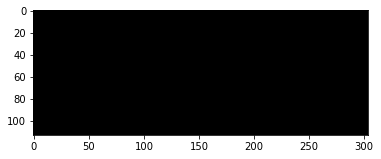

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220418T082611_20220418T083304_T37TDN_cut_reprojection_size_6_area2_info.pth


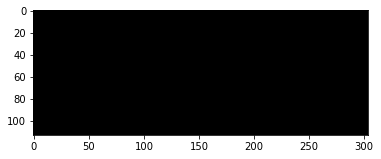

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220428T082611_20220428T083305_T37TCN_cut_reprojection_size_6_area2_info.pth


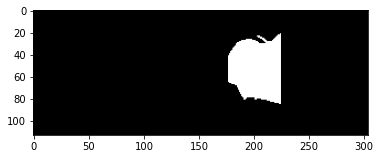

(4, 113, 304, 6, 6)
writing samples 2201


100%|██████████| 2201/2201 [00:00<00:00, 10308.19it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220428T082611_20220428T083305_T37TDN_cut_reprojection_size_6_area2_info.pth


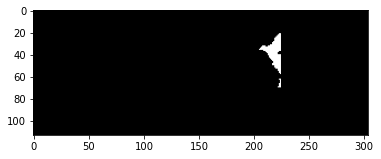

(4, 113, 304, 6, 6)
writing samples 240


100%|██████████| 240/240 [00:00<00:00, 12102.44it/s]


/data4/Ukraine_img/U_band2348/20220503T082559_20220503T083512_T37TCN_cut_reprojection_size_6_area2_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


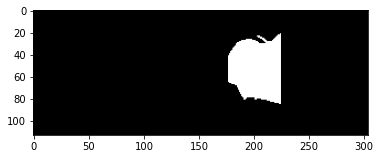

(4, 113, 304, 6, 6)
writing samples 2201


100%|██████████| 2201/2201 [00:00<00:00, 10207.86it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220503T082559_20220503T083512_T37TDN_cut_reprojection_size_6_area2_info.pth


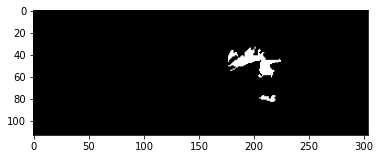

(4, 113, 304, 6, 6)
writing samples 389


100%|██████████| 389/389 [00:00<00:00, 7987.70it/s]




C
loading mask: C
/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C-Area2_2022-05-08_size_3_dammask.pth.tar
load img: C
['/data4/Ukraine_img/U_band2348/20220508T082611_20220508T083304_T37TCN_cut_reprojection_size_6_area2_info.pth', '/data4/Ukraine_img/U_band2348/20220508T082611_20220508T083304_T37TDN_cut_reprojection_size_6_area2_info.pth']
/data4/Ukraine_img/U_band2348/20220508T082611_20220508T083304_T37TCN_cut_reprojection_size_6_area2_info.pth


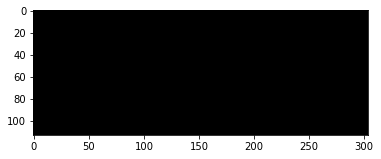

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220508T082611_20220508T083304_T37TDN_cut_reprojection_size_6_area2_info.pth


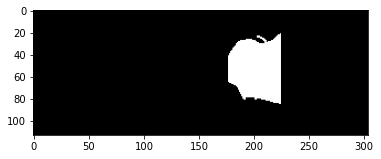

(4, 113, 304, 6, 6)
writing samples 2271


100%|██████████| 2271/2271 [00:00<00:00, 11162.46it/s]




C-Z
loading mask: C
/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C-Area2_2022-05-08_size_3_dammask.pth.tar
load img: C-Z
['/data4/Ukraine_img/U_band2348/20220513T082559_20220513T082940_T37TCN_cut_reprojection_size_6_area2_info.pth', '/data4/Ukraine_img/U_band2348/20220513T082559_20220513T082940_T37TDN_cut_reprojection_size_6_area2_info.pth', '/data4/Ukraine_img/U_band2348/20220523T082559_20220523T082946_T37TCN_cut_reprojection_size_6_area2_info.pth', '/data4/Ukraine_img/U_band2348/20220523T082559_20220523T082946_T37TDN_cut_reprojection_size_6_area2_info.pth', '/data4/Ukraine_img/U_band2348/20220528T082611_20220528T083641_T37TCN_cut_reprojection_size_6_area2_info.pth', '/data4/Ukraine_img/U_band2348/20220528T082611_20220528T083641_T37TDN_cut_reprojection_size_6_area2_info.pth', '/data4/Ukraine_img/U_band2348/20220602T082559_20220602T082807_T37TCN_cut_reprojection_size_6_area2_info.pth', '/data4/Ukraine_img/U_band2348/20220602T082559_20220602T082807_T37TDN_cut_reprojectio

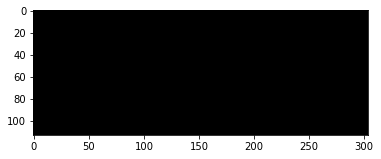

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]

/data4/Ukraine_img/U_band2348/20220513T082559_20220513T082940_T37TDN_cut_reprojection_size_6_area2_info.pth


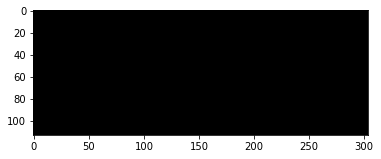

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220523T082559_20220523T082946_T37TCN_cut_reprojection_size_6_area2_info.pth


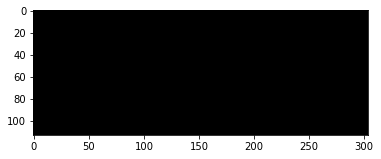

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220523T082559_20220523T082946_T37TDN_cut_reprojection_size_6_area2_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


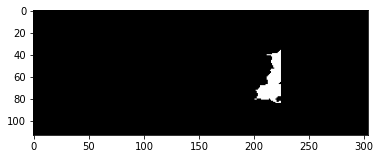

(4, 113, 304, 6, 6)
writing samples 9


100%|██████████| 9/9 [00:00<00:00, 3123.86it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220528T082611_20220528T083641_T37TCN_cut_reprojection_size_6_area2_info.pth


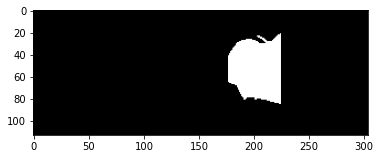

(4, 113, 304, 6, 6)
writing samples 71


100%|██████████| 71/71 [00:00<00:00, 4483.12it/s]


/data4/Ukraine_img/U_band2348/20220528T082611_20220528T083641_T37TDN_cut_reprojection_size_6_area2_info.pth


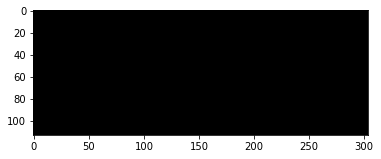

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220602T082559_20220602T082807_T37TCN_cut_reprojection_size_6_area2_info.pth


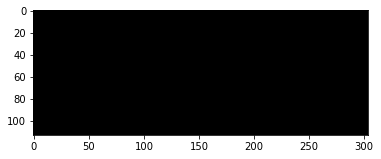

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220602T082559_20220602T082807_T37TDN_cut_reprojection_size_6_area2_info.pth


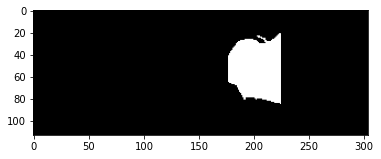

(4, 113, 304, 6, 6)
writing samples 71


100%|██████████| 71/71 [00:00<00:00, 3975.48it/s]


/data4/Ukraine_img/U_band2348/20220607T082611_20220607T083435_T37TCN_cut_reprojection_size_6_area2_info.pth


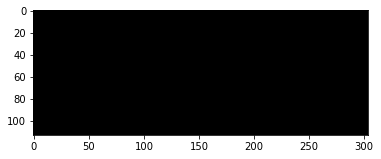

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220607T082611_20220607T083435_T37TDN_cut_reprojection_size_6_area2_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


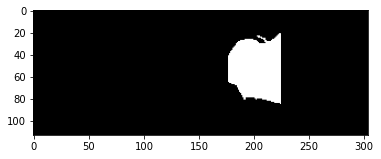

(4, 113, 304, 6, 6)
writing samples 71


100%|██████████| 71/71 [00:00<00:00, 4416.43it/s]


/data4/Ukraine_img/U_band2348/20220612T082609_20220612T082840_T37TCN_cut_reprojection_size_6_area2_info.pth


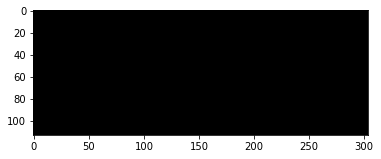

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220612T082609_20220612T082840_T37TDN_cut_reprojection_size_6_area2_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


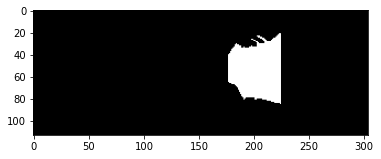

(4, 113, 304, 6, 6)
writing samples 69


100%|██████████| 69/69 [00:00<00:00, 4014.86it/s]


/data4/Ukraine_img/U_band2348/20220617T082611_20220617T083253_T37TCN_cut_reprojection_size_6_area2_info.pth


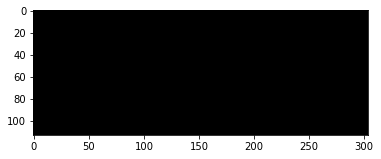

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220617T082611_20220617T083253_T37TDN_cut_reprojection_size_6_area2_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


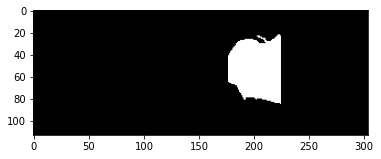

(4, 113, 304, 6, 6)
writing samples 71


100%|██████████| 71/71 [00:00<00:00, 2474.17it/s]


/data4/Ukraine_img/U_band2348/20220622T082609_20220622T082834_T37TCN_cut_reprojection_size_6_area2_info.pth


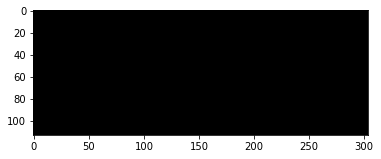

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220622T082609_20220622T082834_T37TDN_cut_reprojection_size_6_area2_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


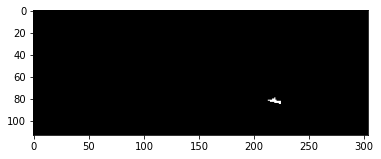

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220627T082621_20220627T083534_T37TCN_cut_reprojection_size_6_area2_info.pth


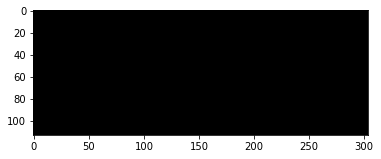

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220627T082621_20220627T083534_T37TDN_cut_reprojection_size_6_area2_info.pth


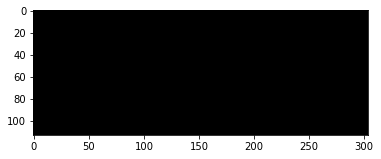

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


-------------------------------------
['A', 'A-B', 'B', 'B-Z']


A-B
loading mask: B
/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_B_2022-03-14_size_3_dammask.pth.tar
load img: A-B
['/data4/Ukraine_img/U_band2348/20220222T082839_20220222T082842_T37TCN_cut_reprojection_size_6_area3_info.pth', '/data4/Ukraine_img/U_band2348/20220222T082839_20220222T082842_T37TDN_cut_reprojection_size_6_area3_info.pth', '/data4/Ukraine_img/U_band2348/20220227T082911_20220227T083303_T37TCN_cut_reprojection_size_6_area3_info.pth', '/data4/Ukraine_img/U_band2348/20220309T082801_20220309T083304_T37TCN_cut_reprojection_size_6_area3_info.pth', '/data4/Ukraine_img/U_band2348/20220309T082801_20220309T083304_T37TDN_cut_reprojection_size_6_area3_info.pth']
/data4/Ukraine_img/U_band2348/20220222T082839_20220222T082842_T37TCN_cut_reprojection_size_6_area3_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


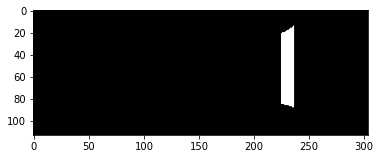

(4, 113, 304, 6, 6)
writing samples 806


100%|██████████| 806/806 [00:00<00:00, 9640.98it/s]


/data4/Ukraine_img/U_band2348/20220222T082839_20220222T082842_T37TDN_cut_reprojection_size_6_area3_info.pth


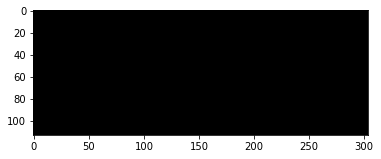

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220227T082911_20220227T083303_T37TCN_cut_reprojection_size_6_area3_info.pth


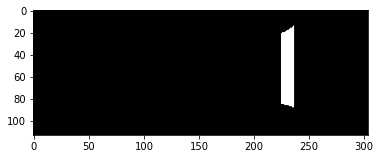

(4, 113, 304, 6, 6)
writing samples 806


100%|██████████| 806/806 [00:00<00:00, 7364.31it/s]


/data4/Ukraine_img/U_band2348/20220309T082801_20220309T083304_T37TCN_cut_reprojection_size_6_area3_info.pth


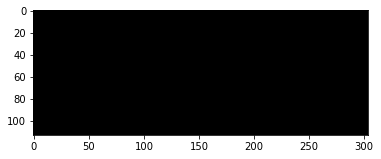

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220309T082801_20220309T083304_T37TDN_cut_reprojection_size_6_area3_info.pth


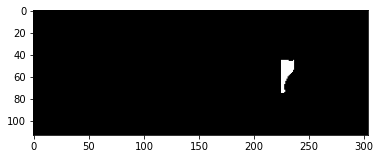

(4, 113, 304, 6, 6)
writing samples 190


100%|██████████| 190/190 [00:00<00:00, 7228.80it/s]




B
loading mask: B
/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_B_2022-03-14_size_3_dammask.pth.tar
load img: B
['/data4/Ukraine_img/U_band2348/20220314T082719_20220314T083610_T37TCN_cut_reprojection_size_6_area3_info.pth', '/data4/Ukraine_img/U_band2348/20220314T082719_20220314T083610_T37TDN_cut_reprojection_size_6_area3_info.pth']
/data4/Ukraine_img/U_band2348/20220314T082719_20220314T083610_T37TCN_cut_reprojection_size_6_area3_info.pth


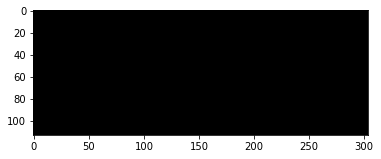

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220314T082719_20220314T083610_T37TDN_cut_reprojection_size_6_area3_info.pth


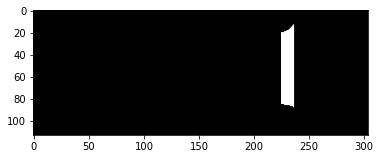

(4, 113, 304, 6, 6)
writing samples 808


100%|██████████| 808/808 [00:00<00:00, 9908.45it/s]




B-Z
loading mask: B
/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_B_2022-03-14_size_3_dammask.pth.tar
load img: B-Z
['/data4/Ukraine_img/U_band2348/20220319T082651_20220319T083304_T37TCN_cut_reprojection_size_6_area3_info.pth', '/data4/Ukraine_img/U_band2348/20220319T082651_20220319T083304_T37TDN_cut_reprojection_size_6_area3_info.pth', '/data4/Ukraine_img/U_band2348/20220324T082609_20220324T083426_T37TCN_cut_reprojection_size_6_area3_info.pth', '/data4/Ukraine_img/U_band2348/20220324T082609_20220324T083426_T37TDN_cut_reprojection_size_6_area3_info.pth', '/data4/Ukraine_img/U_band2348/20220329T082601_20220329T083216_T37TCN_cut_reprojection_size_6_area3_info.pth', '/data4/Ukraine_img/U_band2348/20220329T082601_20220329T083216_T37TDN_cut_reprojection_size_6_area3_info.pth', '/data4/Ukraine_img/U_band2348/20220403T082559_20220403T083553_T37TCN_cut_reprojection_size_6_area3_info.pth', '/data4/Ukraine_img/U_band2348/20220403T082559_20220403T083553_T37TDN_cut_reprojection_size

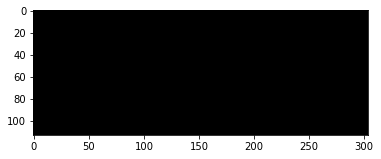

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220319T082651_20220319T083304_T37TDN_cut_reprojection_size_6_area3_info.pth


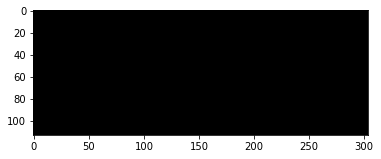

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220324T082609_20220324T083426_T37TCN_cut_reprojection_size_6_area3_info.pth


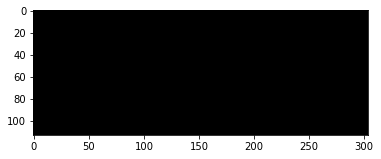

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220324T082609_20220324T083426_T37TDN_cut_reprojection_size_6_area3_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


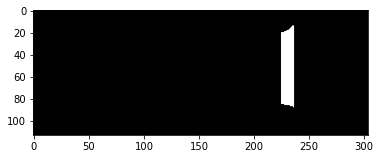

(4, 113, 304, 6, 6)
writing samples 3


100%|██████████| 3/3 [00:00<00:00, 2045.34it/s]


/data4/Ukraine_img/U_band2348/20220329T082601_20220329T083216_T37TCN_cut_reprojection_size_6_area3_info.pth


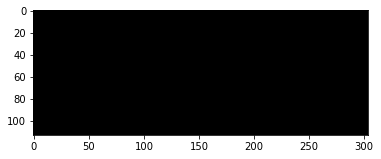

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220329T082601_20220329T083216_T37TDN_cut_reprojection_size_6_area3_info.pth


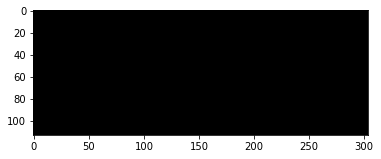

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220403T082559_20220403T083553_T37TCN_cut_reprojection_size_6_area3_info.pth


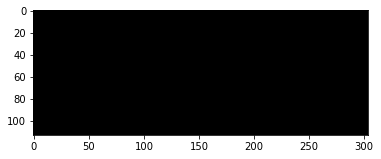

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220403T082559_20220403T083553_T37TDN_cut_reprojection_size_6_area3_info.pth


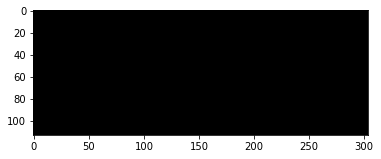

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220408T082601_20220408T083258_T37TDN_cut_reprojection_size_6_area3_info.pth


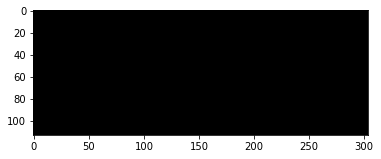

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220418T082611_20220418T083304_T37TCN_cut_reprojection_size_6_area3_info.pth


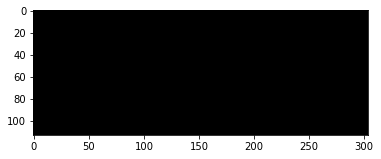

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]

/data4/Ukraine_img/U_band2348/20220418T082611_20220418T083304_T37TDN_cut_reprojection_size_6_area3_info.pth


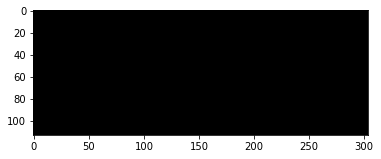

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220428T082611_20220428T083305_T37TCN_cut_reprojection_size_6_area3_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


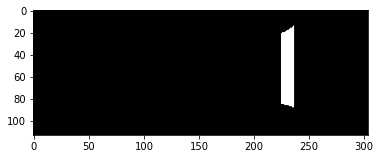

(4, 113, 304, 6, 6)
writing samples 3


100%|██████████| 3/3 [00:00<00:00, 2201.73it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220428T082611_20220428T083305_T37TDN_cut_reprojection_size_6_area3_info.pth


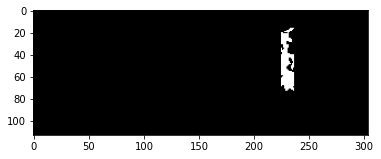

(4, 113, 304, 6, 6)
writing samples 3


100%|██████████| 3/3 [00:00<00:00, 1720.62it/s]


/data4/Ukraine_img/U_band2348/20220503T082559_20220503T083512_T37TCN_cut_reprojection_size_6_area3_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


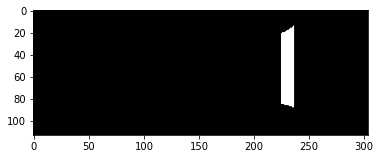

(4, 113, 304, 6, 6)
writing samples 3


100%|██████████| 3/3 [00:00<00:00, 2240.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220503T082559_20220503T083512_T37TDN_cut_reprojection_size_6_area3_info.pth


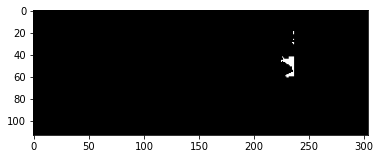

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220513T082559_20220513T082940_T37TCN_cut_reprojection_size_6_area3_info.pth


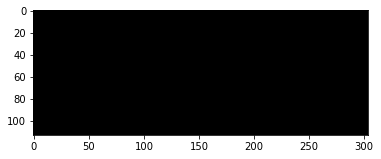

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220513T082559_20220513T082940_T37TDN_cut_reprojection_size_6_area3_info.pth


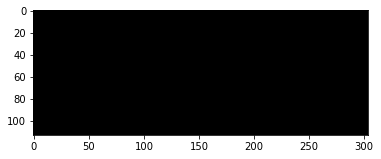

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220523T082559_20220523T082946_T37TCN_cut_reprojection_size_6_area3_info.pth


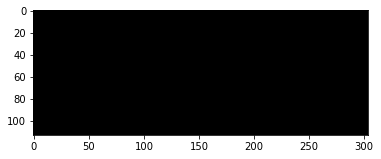

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220523T082559_20220523T082946_T37TDN_cut_reprojection_size_6_area3_info.pth


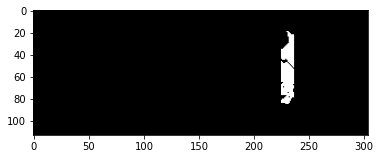

(4, 113, 304, 6, 6)
writing samples 3


100%|██████████| 3/3 [00:00<00:00, 1692.84it/s]


/data4/Ukraine_img/U_band2348/20220528T082611_20220528T083641_T37TCN_cut_reprojection_size_6_area3_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


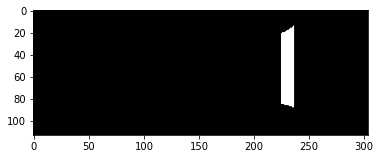

(4, 113, 304, 6, 6)
writing samples 3


100%|██████████| 3/3 [00:00<00:00, 1900.17it/s]


/data4/Ukraine_img/U_band2348/20220528T082611_20220528T083641_T37TDN_cut_reprojection_size_6_area3_info.pth


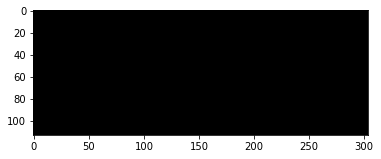

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220602T082559_20220602T082807_T37TCN_cut_reprojection_size_6_area3_info.pth


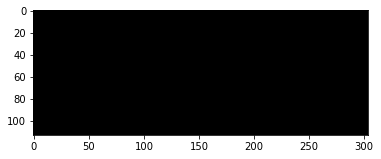

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220602T082559_20220602T082807_T37TDN_cut_reprojection_size_6_area3_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


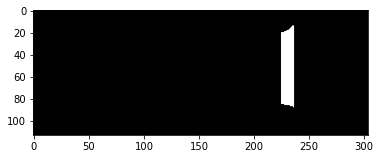

(4, 113, 304, 6, 6)
writing samples 3


100%|██████████| 3/3 [00:00<00:00, 325.45it/s]


/data4/Ukraine_img/U_band2348/20220607T082611_20220607T083435_T37TCN_cut_reprojection_size_6_area3_info.pth


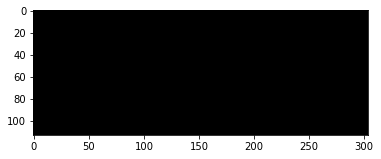

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220607T082611_20220607T083435_T37TDN_cut_reprojection_size_6_area3_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


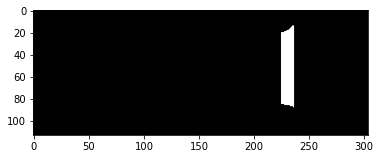

(4, 113, 304, 6, 6)
writing samples 3


100%|██████████| 3/3 [00:00<00:00, 1374.73it/s]


/data4/Ukraine_img/U_band2348/20220612T082609_20220612T082840_T37TCN_cut_reprojection_size_6_area3_info.pth


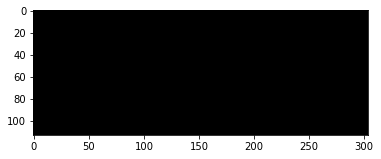

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220612T082609_20220612T082840_T37TDN_cut_reprojection_size_6_area3_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


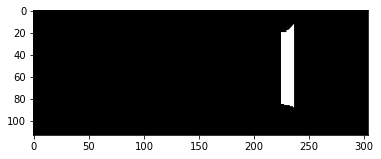

(4, 113, 304, 6, 6)
writing samples 3


100%|██████████| 3/3 [00:00<00:00, 1944.51it/s]


/data4/Ukraine_img/U_band2348/20220617T082611_20220617T083253_T37TCN_cut_reprojection_size_6_area3_info.pth


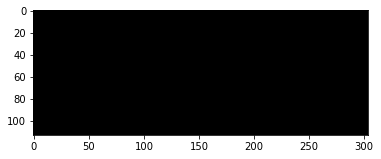

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220617T082611_20220617T083253_T37TDN_cut_reprojection_size_6_area3_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


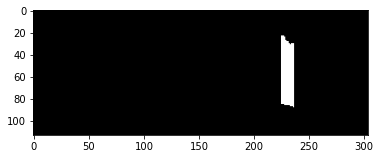

(4, 113, 304, 6, 6)
writing samples 3


100%|██████████| 3/3 [00:00<00:00, 1978.76it/s]


/data4/Ukraine_img/U_band2348/20220622T082609_20220622T082834_T37TCN_cut_reprojection_size_6_area3_info.pth


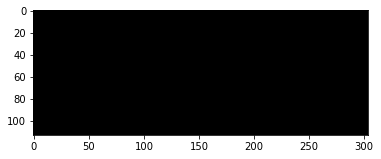

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220622T082609_20220622T082834_T37TDN_cut_reprojection_size_6_area3_info.pth


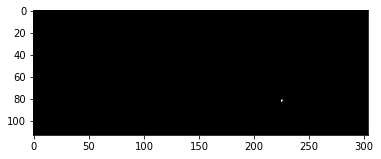

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220627T082621_20220627T083534_T37TCN_cut_reprojection_size_6_area3_info.pth


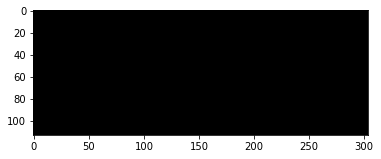

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220627T082621_20220627T083534_T37TDN_cut_reprojection_size_6_area3_info.pth


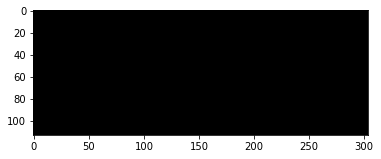

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


-------------------------------------
['A', 'A-B', 'B', 'B-C', 'C', 'C-Z']


A-B
loading mask: B
/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_B_2022-03-14_size_3_dammask.pth.tar
load img: A-B
['/data4/Ukraine_img/U_band2348/20220222T082839_20220222T082842_T37TCN_cut_reprojection_size_6_area4_info.pth', '/data4/Ukraine_img/U_band2348/20220222T082839_20220222T082842_T37TDN_cut_reprojection_size_6_area4_info.pth', '/data4/Ukraine_img/U_band2348/20220227T082911_20220227T083303_T37TCN_cut_reprojection_size_6_area4_info.pth', '/data4/Ukraine_img/U_band2348/20220309T082801_20220309T083304_T37TCN_cut_reprojection_size_6_area4_info.pth', '/data4/Ukraine_img/U_band2348/20220309T082801_20220309T083304_T37TDN_cut_reprojection_size_6_area4_info.pth']
/data4/Ukraine_img/U_band2348/20220222T082839_20220222T082842_T37TCN_cut_reprojection_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


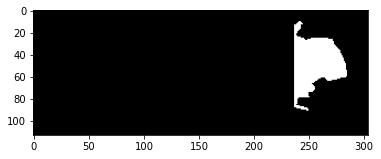

(4, 113, 304, 6, 6)
writing samples 1870


100%|██████████| 1870/1870 [00:00<00:00, 10612.96it/s]


/data4/Ukraine_img/U_band2348/20220222T082839_20220222T082842_T37TDN_cut_reprojection_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


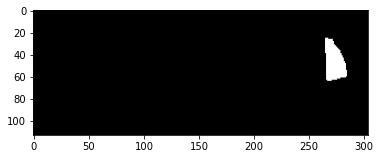

(4, 113, 304, 6, 6)
writing samples 493


100%|██████████| 493/493 [00:00<00:00, 9182.23it/s]


/data4/Ukraine_img/U_band2348/20220227T082911_20220227T083303_T37TCN_cut_reprojection_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


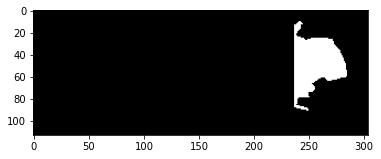

(4, 113, 304, 6, 6)
writing samples 1870


100%|██████████| 1870/1870 [00:00<00:00, 9016.00it/s]


/data4/Ukraine_img/U_band2348/20220309T082801_20220309T083304_T37TCN_cut_reprojection_size_6_area4_info.pth


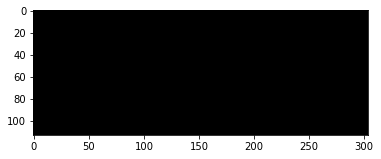

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220309T082801_20220309T083304_T37TDN_cut_reprojection_size_6_area4_info.pth


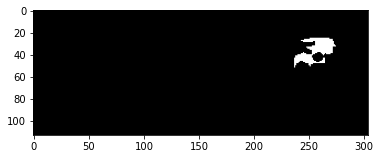

(4, 113, 304, 6, 6)
writing samples 379


100%|██████████| 379/379 [00:00<00:00, 7432.57it/s]




B
loading mask: B
/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_B_2022-03-14_size_3_dammask.pth.tar
load img: B
['/data4/Ukraine_img/U_band2348/20220314T082719_20220314T083610_T37TCN_cut_reprojection_size_6_area4_info.pth', '/data4/Ukraine_img/U_band2348/20220314T082719_20220314T083610_T37TDN_cut_reprojection_size_6_area4_info.pth']
/data4/Ukraine_img/U_band2348/20220314T082719_20220314T083610_T37TCN_cut_reprojection_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


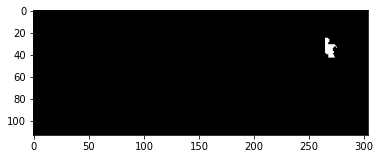

(4, 113, 304, 6, 6)
writing samples 74


100%|██████████| 74/74 [00:00<00:00, 6036.38it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220314T082719_20220314T083610_T37TDN_cut_reprojection_size_6_area4_info.pth


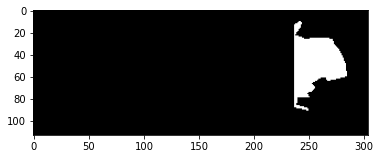

(4, 113, 304, 6, 6)
writing samples 1865


100%|██████████| 1865/1865 [00:00<00:00, 9914.32it/s] 




B-C
loading mask: B and C
/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_B_2022-03-14_size_3_dammask.pth.tar
/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C-Area1-4_2022-05-07_size_3_dammask.pth.tar
load img: B-C
['/data4/Ukraine_img/U_band2348/20220319T082651_20220319T083304_T37TCN_cut_reprojection_size_6_area4_info.pth', '/data4/Ukraine_img/U_band2348/20220319T082651_20220319T083304_T37TDN_cut_reprojection_size_6_area4_info.pth', '/data4/Ukraine_img/U_band2348/20220324T082609_20220324T083426_T37TCN_cut_reprojection_size_6_area4_info.pth', '/data4/Ukraine_img/U_band2348/20220324T082609_20220324T083426_T37TDN_cut_reprojection_size_6_area4_info.pth', '/data4/Ukraine_img/U_band2348/20220329T082601_20220329T083216_T37TCN_cut_reprojection_size_6_area4_info.pth', '/data4/Ukraine_img/U_band2348/20220329T082601_20220329T083216_T37TDN_cut_reprojection_size_6_area4_info.pth', '/data4/Ukraine_img/U_band2348/20220403T082559_20220403T083553_T37TCN_cut_reprojection_size_6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


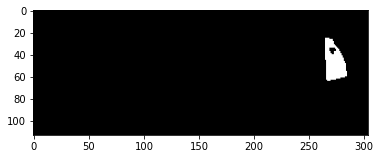

(4, 113, 304, 6, 6)
writing samples 453


100%|██████████| 453/453 [00:00<00:00, 9380.68it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220319T082651_20220319T083304_T37TDN_cut_reprojection_size_6_area4_info.pth


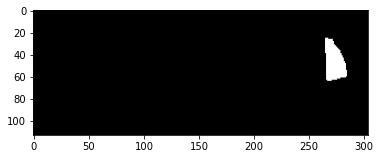

(4, 113, 304, 6, 6)
writing samples 492


100%|██████████| 492/492 [00:00<00:00, 8870.42it/s]


/data4/Ukraine_img/U_band2348/20220324T082609_20220324T083426_T37TCN_cut_reprojection_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


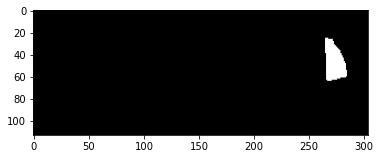

(4, 113, 304, 6, 6)
writing samples 492


100%|██████████| 492/492 [00:00<00:00, 8859.11it/s]


/data4/Ukraine_img/U_band2348/20220324T082609_20220324T083426_T37TDN_cut_reprojection_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


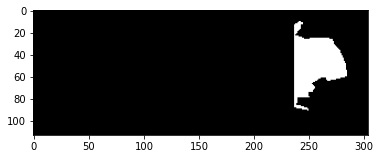

(4, 113, 304, 6, 6)
writing samples 1839


100%|██████████| 1839/1839 [00:00<00:00, 11192.88it/s]


/data4/Ukraine_img/U_band2348/20220329T082601_20220329T083216_T37TCN_cut_reprojection_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


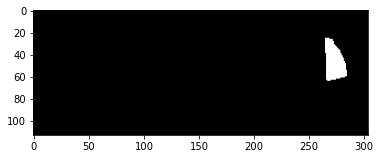

(4, 113, 304, 6, 6)
writing samples 491


100%|██████████| 491/491 [00:00<00:00, 11190.65it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220329T082601_20220329T083216_T37TDN_cut_reprojection_size_6_area4_info.pth


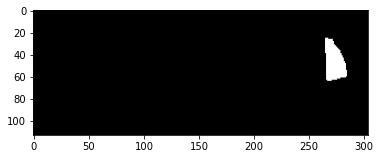

(4, 113, 304, 6, 6)
writing samples 492


100%|██████████| 492/492 [00:00<00:00, 11618.24it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220403T082559_20220403T083553_T37TCN_cut_reprojection_size_6_area4_info.pth


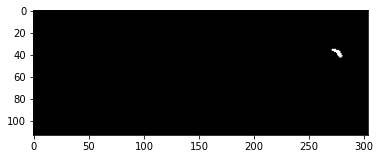

(4, 113, 304, 6, 6)
writing samples 22


100%|██████████| 22/22 [00:00<00:00, 3032.46it/s]


/data4/Ukraine_img/U_band2348/20220403T082559_20220403T083553_T37TDN_cut_reprojection_size_6_area4_info.pth


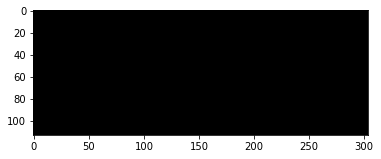

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220408T082601_20220408T083258_T37TDN_cut_reprojection_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


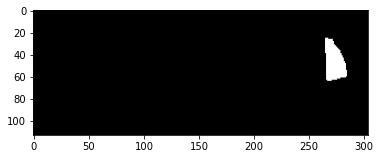

(4, 113, 304, 6, 6)
writing samples 492


100%|██████████| 492/492 [00:00<00:00, 8387.48it/s]


/data4/Ukraine_img/U_band2348/20220418T082611_20220418T083304_T37TCN_cut_reprojection_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


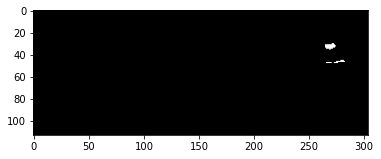

(4, 113, 304, 6, 6)
writing samples 32


100%|██████████| 32/32 [00:00<00:00, 3532.14it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220418T082611_20220418T083304_T37TDN_cut_reprojection_size_6_area4_info.pth


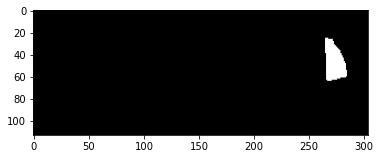

(4, 113, 304, 6, 6)
writing samples 492


100%|██████████| 492/492 [00:00<00:00, 7117.92it/s]


/data4/Ukraine_img/U_band2348/20220428T082611_20220428T083305_T37TCN_cut_reprojection_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


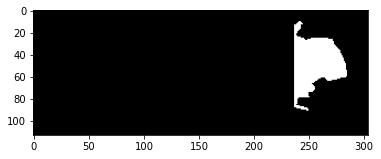

(4, 113, 304, 6, 6)
writing samples 1848


100%|██████████| 1848/1848 [00:00<00:00, 11121.91it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220428T082611_20220428T083305_T37TDN_cut_reprojection_size_6_area4_info.pth


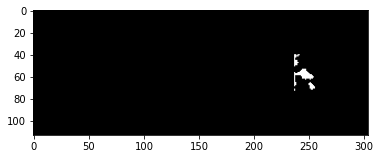

(4, 113, 304, 6, 6)
writing samples 96


100%|██████████| 96/96 [00:00<00:00, 3135.66it/s]


/data4/Ukraine_img/U_band2348/20220503T082559_20220503T083512_T37TCN_cut_reprojection_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


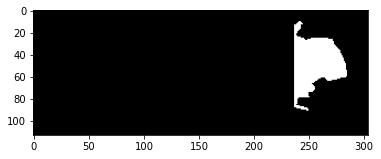

(4, 113, 304, 6, 6)
writing samples 1848


100%|██████████| 1848/1848 [00:00<00:00, 9869.53it/s] 
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220503T082559_20220503T083512_T37TDN_cut_reprojection_size_6_area4_info.pth


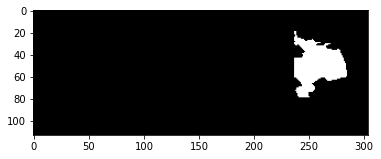

(4, 113, 304, 6, 6)
writing samples 1443


100%|██████████| 1443/1443 [00:00<00:00, 7616.48it/s]




C
loading mask: C
/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C-Area1-4_2022-05-07_size_3_dammask.pth.tar


C-Z
loading mask: C
/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C-Area1-4_2022-05-07_size_3_dammask.pth.tar
load img: C-Z
['/data4/Ukraine_img/U_band2348/20220508T082611_20220508T083304_T37TCN_cut_reprojection_size_6_area4_info.pth', '/data4/Ukraine_img/U_band2348/20220508T082611_20220508T083304_T37TDN_cut_reprojection_size_6_area4_info.pth', '/data4/Ukraine_img/U_band2348/20220513T082559_20220513T082940_T37TCN_cut_reprojection_size_6_area4_info.pth', '/data4/Ukraine_img/U_band2348/20220513T082559_20220513T082940_T37TDN_cut_reprojection_size_6_area4_info.pth', '/data4/Ukraine_img/U_band2348/20220523T082559_20220523T082946_T37TCN_cut_reprojection_size_6_area4_info.pth', '/data4/Ukraine_img/U_band2348/20220523T082559_20220523T082946_T37TDN_cut_reprojection_size_6_area4_info.pth', '/data4/Ukraine_img/U_band2348/20220528T082611_20220528T083641_T37TCN_c

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


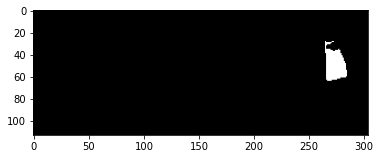

(4, 113, 304, 6, 6)
writing samples 1


100%|██████████| 1/1 [00:00<00:00, 1086.89it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220508T082611_20220508T083304_T37TDN_cut_reprojection_size_6_area4_info.pth


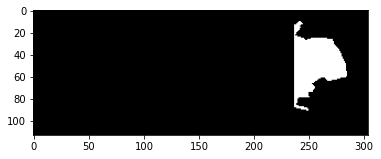

(4, 113, 304, 6, 6)
writing samples 46


100%|██████████| 46/46 [00:00<00:00, 3863.94it/s]


/data4/Ukraine_img/U_band2348/20220513T082559_20220513T082940_T37TCN_cut_reprojection_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


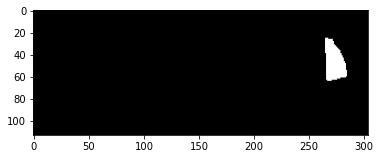

(4, 113, 304, 6, 6)
writing samples 1


100%|██████████| 1/1 [00:00<00:00, 1031.05it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220513T082559_20220513T082940_T37TDN_cut_reprojection_size_6_area4_info.pth


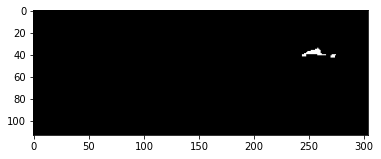

(4, 113, 304, 6, 6)
writing samples 4


100%|██████████| 4/4 [00:00<00:00, 2169.00it/s]


/data4/Ukraine_img/U_band2348/20220523T082559_20220523T082946_T37TCN_cut_reprojection_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


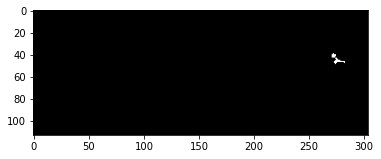

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220523T082559_20220523T082946_T37TDN_cut_reprojection_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


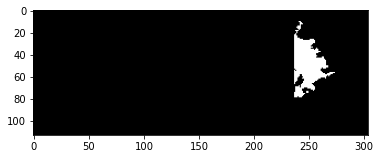

(4, 113, 304, 6, 6)
writing samples 21


100%|██████████| 21/21 [00:00<00:00, 5906.28it/s]


/data4/Ukraine_img/U_band2348/20220528T082611_20220528T083641_T37TCN_cut_reprojection_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


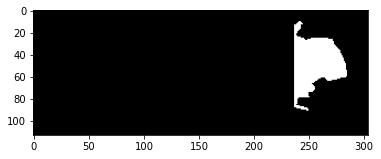

(4, 113, 304, 6, 6)
writing samples 46


100%|██████████| 46/46 [00:00<00:00, 3543.79it/s]


/data4/Ukraine_img/U_band2348/20220528T082611_20220528T083641_T37TDN_cut_reprojection_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


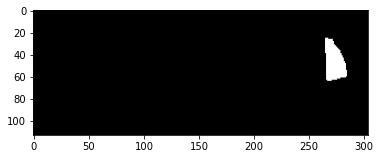

(4, 113, 304, 6, 6)
writing samples 1


100%|██████████| 1/1 [00:00<00:00, 1189.87it/s]


/data4/Ukraine_img/U_band2348/20220602T082559_20220602T082807_T37TCN_cut_reprojection_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


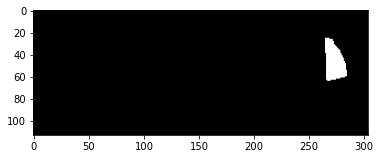

(4, 113, 304, 6, 6)
writing samples 1


100%|██████████| 1/1 [00:00<00:00, 1443.82it/s]


/data4/Ukraine_img/U_band2348/20220602T082559_20220602T082807_T37TDN_cut_reprojection_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


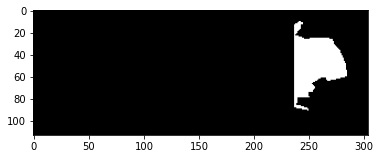

(4, 113, 304, 6, 6)
writing samples 46


100%|██████████| 46/46 [00:00<00:00, 3585.74it/s]


/data4/Ukraine_img/U_band2348/20220607T082611_20220607T083435_T37TCN_cut_reprojection_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


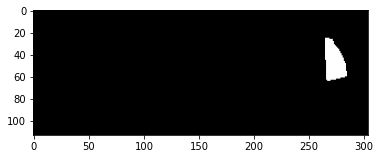

(4, 113, 304, 6, 6)
writing samples 1


100%|██████████| 1/1 [00:00<00:00, 110.71it/s]


/data4/Ukraine_img/U_band2348/20220607T082611_20220607T083435_T37TDN_cut_reprojection_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


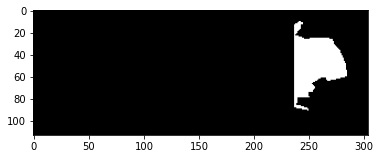

(4, 113, 304, 6, 6)
writing samples 46


100%|██████████| 46/46 [00:00<00:00, 4019.12it/s]


/data4/Ukraine_img/U_band2348/20220612T082609_20220612T082840_T37TCN_cut_reprojection_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


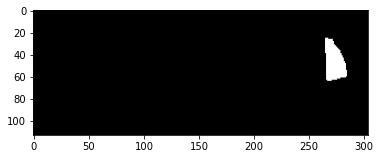

(4, 113, 304, 6, 6)
writing samples 1


100%|██████████| 1/1 [00:00<00:00, 1117.88it/s]


/data4/Ukraine_img/U_band2348/20220612T082609_20220612T082840_T37TDN_cut_reprojection_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


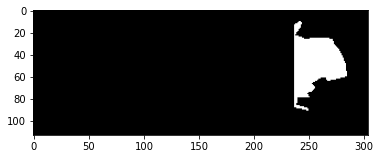

(4, 113, 304, 6, 6)
writing samples 46


100%|██████████| 46/46 [00:00<00:00, 3540.34it/s]


/data4/Ukraine_img/U_band2348/20220617T082611_20220617T083253_T37TCN_cut_reprojection_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


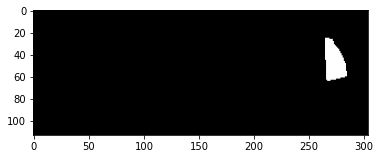

(4, 113, 304, 6, 6)
writing samples 1


100%|██████████| 1/1 [00:00<00:00, 993.44it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220617T082611_20220617T083253_T37TDN_cut_reprojection_size_6_area4_info.pth


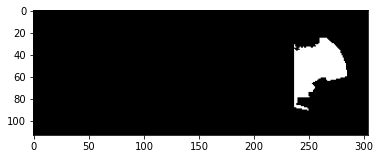

(4, 113, 304, 6, 6)
writing samples 46


100%|██████████| 46/46 [00:00<00:00, 3689.98it/s]


/data4/Ukraine_img/U_band2348/20220622T082609_20220622T082834_T37TCN_cut_reprojection_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


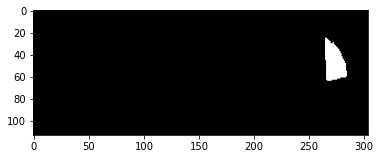

(4, 113, 304, 6, 6)
writing samples 1


100%|██████████| 1/1 [00:00<00:00, 1097.12it/s]


/data4/Ukraine_img/U_band2348/20220622T082609_20220622T082834_T37TDN_cut_reprojection_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


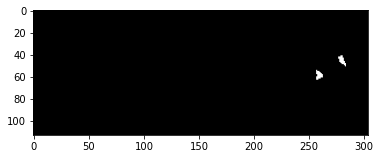

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]


/data4/Ukraine_img/U_band2348/20220627T082621_20220627T083534_T37TCN_cut_reprojection_size_6_area4_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


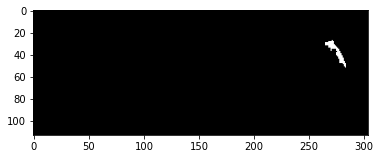

(4, 113, 304, 6, 6)
writing samples 0


0it [00:00, ?it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/U_band2348/20220627T082621_20220627T083534_T37TDN_cut_reprojection_size_6_area4_info.pth


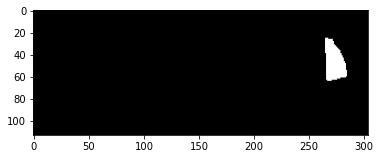

(4, 113, 304, 6, 6)
writing samples 1


100%|██████████| 1/1 [00:00<00:00, 1066.98it/s]


In [54]:
cities=dammasks_path.keys()
for city in cities:
    print('-------------------------------------')
    cityimg_pathes10=img_pathes[city]

    # print(city)
    masks10=dammasks_path[city]

    # print(masks)
    k_interval=list(cityimg_pathes10.keys())

    print(k_interval)
    k_interval.remove('A')
    for k_ in k_interval:
        print()
        print()
        print(k_)
        if len(k_)==1:
            print('loading mask:',k_)
            print(masks10[k_])
            mask_now=torch.load(masks10[k_])
            mask_before=None
            mask_after=None
        else:
            if 'A' in k_:
                print('loading mask:',k_[2])
                print(masks10[k_[2]])
                mask_now=None
                mask_before=None
                mask_after=torch.load(masks10[k_[2]])
            elif 'Z' in k_:
                print('loading mask:',k_[0])
                print(masks10[k_[0]])
                mask_now=None
                mask_before=torch.load(masks10[k_[0]])
                mask_after=None
            else:
                print('loading mask:',k_[0],'and',k_[2])
                print(masks10[k_[0]])
                print(masks10[k_[2]])
                mask_now=None
                mask_before=torch.load(masks10[k_[0]])
                mask_after=torch.load(masks10[k_[2]])  
        pre10_path=cityimg_pathes10['A'][0]
        pre20_path=pre10_path.replace('size_6','size_3').replace('band2348','bandother')
        pre_img=[torch.load(pre10_path)['img'],torch.load(pre20_path)['img']]
        post10_pathes=cityimg_pathes10[k_]
        if len(post10_pathes)==0:
            continue
        post10_pathes.sort()
        print('load img:',k_)
        print(post10_pathes)
        for post10_path in post10_pathes:
            print(post10_path)
            suffix=post10_path.split('_reprojection')[-1].replace('size_6','size_3')
            post20_path=match[post10_path.split('_size')[0]+'.tif'].replace('band2348','bandother').replace('.tif',suffix)
            post_img=[torch.load(post10_path)['img'],torch.load(post20_path)['img']]
            plt.imshow(post_img[0][:3,:,:,1,1].transpose((1,2,0)))
            plt.show()
            samples,zz=get_samples(pre_img,post_img,mask_after,mask_now,mask_before)
            print('writing samples',len(samples))
            time.sleep(2)


            samples_root='/ssd/hk/Ukraine_samples/samplesv1/samples/'
            img_id=os.path.basename(post10_path).split('_cut')[0].replace('_','-')

            samples_pathes=[samples_root+f'{city}_{img_id}_{str(i[0][0]).zfill(3)+str(i[0][1]).zfill(3)}.pth' for i in samples]
            info=[]

            for i in tqdm(range(len(samples))):
                    # '5层分别为完全 严重 中等 以及损毁得分和类型\n得分:完全算6分 严重算3分 中等算1分 其他0分\n类型0:得分0 类型1:得分1-5 类型2:得分大于6'
                    info.append([samples_pathes[i],samples[i][0],samples[i][1]])
                    torch.save(samples[i],samples_pathes[i])
            info_dict={'readme':'4个字段\n 1:pre图像路径\n 2:post图像路径\n 3:图像坐标\n 4:损毁信息\n 损毁信息有5层\n 5层分别为完全 严重 中等 以及损毁得分和类型\n得分:完全算6分 严重算3分 中等算1分 其他0分\n类型0:得分0 类型1:得分1-5 类型2:得分大于6', 'info':info}
            torch.save(info_dict,f'/ssd/hk/Ukraine_samples/samplesv1/{city}_{img_id}_samples_info.pth')
            # if post10_path=='/data4/Ukraine_img/U_band2348/20220314T082719_20220314T083610_T37TDN_cut_reprojection_size_6_area1_info.pth':
            #     raise

# 创建samples_slip文件

area1
/data4/Ukraine_img/U_band2348/20210910T082601_20210910T083119_T37TCN_cut_reprojection_size_6_area1_info.pth
t:1898   v:815


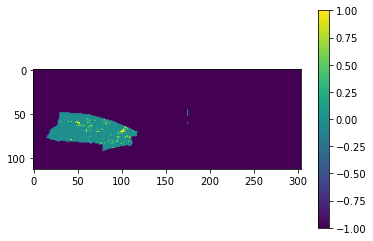

area2
/data4/Ukraine_img/U_band2348/20210910T082601_20210910T083119_T37TCN_cut_reprojection_size_6_area2_info.pth
t:1589   v:683


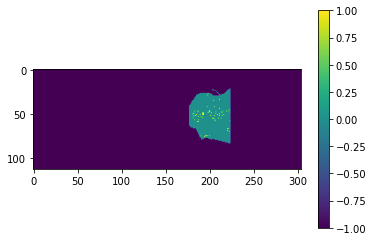

area3
/data4/Ukraine_img/U_band2348/20210910T082601_20210910T083119_T37TCN_cut_reprojection_size_6_area3_info.pth
t:566   v:244


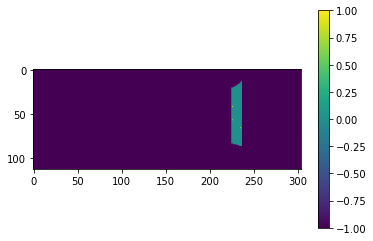

area4
/data4/Ukraine_img/U_band2348/20210910T082601_20210910T083119_T37TCN_cut_reprojection_size_6_area4_info.pth
t:1319   v:566


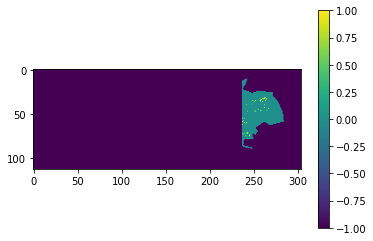

In [73]:
size=6
for city in cities:
    print(city)
    if 'C' in list(dammasks_path[city].keys()):
        dammask_path=dammasks_path[city]['C']
    else:
        dammask_path=dammasks_path[city]['B']

    dammask=torch.load(dammask_path)['mask'][0]
    # plt.imshow(dammask)
    # plt.show()
    mask_path=img_pathes[city]['A'][0]
    print(mask_path)
    mask=torch.load(mask_path)['img'][0]
    mask[mask>0]=1
    # plt.imshow(mask[:,:,0,0])
    # plt.show()
    shape=mask.shape




    sample_mask=np.zeros((shape[0],shape[1]))
    sample_p=[]
    sample_n=[]
    for x in range(shape[0]):
        for y in range(shape[1]):
            if dammask[x,y]>0:
                sample_mask[x,y]=1
            if (mask[x,y]==0).any() and (mask[x,y]==0).any():
                sample_mask[x,y]=-1
            if sample_mask[x,y]==1:
                sample_p.append([x,y])
            elif sample_mask[x,y]==0:
                sample_n.append([x,y])

    p_coord=[str(i[0]).zfill(3)+str(i[1]).zfill(3) for i in sample_p]
    n_coord=[str(i[0]).zfill(3)+str(i[1]).zfill(3) for i in sample_n]
    random.shuffle(p_coord)
    random.shuffle(n_coord)
    p_t_coord=p_coord[:int(len(p_coord)*0.7)]
    p_v_coord=p_coord[int(len(p_coord)*0.7):]
    n_t_coord=n_coord[:int(len(n_coord)*0.7)]
    n_v_coord=n_coord[int(len(n_coord)*0.7):]
    t=p_t_coord+n_t_coord
    v=p_v_coord+n_v_coord
    random.shuffle(t)
    random.shuffle(v)
    print(f't:{len(t)}   v:{len(v)}')
    torch.save(t,f'/ssd/hk/Ukraine_samples/coords_split/{city}_train.pth')
    torch.save(v,f'/ssd/hk/Ukraine_samples/coords_split/{city}_val.pth')
    # plt.figure(figsize=(15,15))
    plt.imshow(sample_mask)
    plt.colorbar()
    plt.show()



In [93]:
def match(string,input_list):
    new_data_list=[i for i in input_list if  re.match(string, i[0]) != None]
    return new_data_list
t=[]
v=[]
city_sample=[]
for i in glob('/ssd/hk/Ukraine_samples/coords_split/*train.pth'):
    t+=torch.load(i)
    v+=torch.load(i.replace('train','val'))
print(len(t),len(v))
for i in glob('/ssd/hk/Ukraine_samples/samplesv1/*.pth'):
    city_sample+=torch.load(i)['info']
print(len(city_sample))

for i in range(len(city_sample)):
    if len(city_sample[i][2])==2:
        if city_sample[i][2][0] is not None:
            city_sample[i][2]=city_sample[i][2][0]
        else:
            city_sample[i][2]=city_sample[i][2][1]
city_pathes=[[i[0],'n'] if i[2][0]==0 else [i[0],'p'] for i in city_sample]
random.shuffle(city_pathes)
import re
city_coord_sample={}
city_coord_sample['train']={}
city_coord_sample['val']={}
print('match train')
time.sleep(2)
for i in tqdm(t):
    a=match(f'.*{i}.*',city_pathes)
    a.sort()
    city_coord_sample['train'][i]=a
print('match val')
time.sleep(2)
for i in tqdm(v):
    a=match(f'.*{i}.*',city_pathes)
    a.sort()
    city_coord_sample['val'][i]=a
torch.save(city_coord_sample,f'/ssd/hk/Ukraine_samples/split_coord_v2/samples.pth') 



t=[]
for i in city_coord_sample['train'].keys():
    t+=city_coord_sample['train'][i]
v=[]
for i in city_coord_sample['val'].keys():
    v+=city_coord_sample['val'][i]
random.shuffle(t)
random.shuffle(v)
torch.save(t,f'/ssd/hk/Ukraine_samples/split_coord_v2/train.pth') 
torch.save(v,f'/ssd/hk/Ukraine_samples/split_coord_v2/val.pth') 

5372 2308
57118
match train


100%|██████████| 5372/5372 [06:15<00:00, 14.31it/s]


match val


100%|██████████| 2308/2308 [02:41<00:00, 14.28it/s]


In [102]:
print(len(t))
len([i  for i in t if i[1]=='p'])

39726


1099

In [101]:
print(len(v))
len([i  for i in v if i[1]=='p'])

17392


495